# 캐글 데이터 연동하기

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eunjijeong","key":"29fdf1c9b4bee7ef56c5520fc84d41dc"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c kaggle-survey-2021
!unzip kaggle_survey_2021_responses.csv.zip

  0% 0.00/55.2k [00:00<?, ?B/s]
100% 55.2k/55.2k [00:00<00:00, 53.4MB/s]
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 49.2MB/s]
  0% 0.00/2.86M [00:00<?, ?B/s]
100% 2.86M/2.86M [00:00<00:00, 93.9MB/s]
Archive:  kaggle_survey_2021_responses.csv.zip
  inflating: kaggle_survey_2021_responses.csv  


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [4]:
response = pd.read_csv('kaggle_survey_2021_responses.csv')
print(response.shape)
response.head(3)

(25974, 369)


,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_Part_12,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,...,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_Part_12,Q34_B_Part_13,Q34_B_Part_14,Q34_B_Part_15,Q34_B_Part_16,Q34_B_OTHER,Q36_B_Part_1,Q36_B_Part_2,Q36_B_Part_3,Q36_B_Part_4,Q36_B_Part_5,Q36_B_Part_6,Q36_B_Part_7,Q36_B_OTHER,Q37_B_Part_1,Q37_B_Part_2,Q37_B_Part_3,Q37_B_Part_4,Q37_B_Part_5,Q37_B_Part_6,Q37_B_Part_7,Q37_B_OTHER,Q38_B_Part_1,Q38_B_Part_2,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming language would you recommend ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool

# 질문 통합

In [5]:
res = response.copy()

# index 0번 질문 삭제
res.drop(0, inplace=True)

In [6]:
def total_answer(column):
  """
  컬럼별로 나누어진 응답을 통합하는 함수
  column : 컬럼명
  """

  # 해당 컬럼명이 들어간 컬럼 추출
  col = res.columns[res.columns.str.contains(column)]
  tmp = res[col]
  # 결측치 ''로 채우기
  tmp = tmp.fillna('')
  # 컬럼별 응답 콤마(,)로 더하기
  total = tmp.apply(','.join, axis=1)

  # 정규표현식으로 필요없는 콤마(,) 처리
  import re
  ls = []
  for i in total:
    ls.append(re.sub(',{2,}', ',', i).strip(',')) ## 콤마가 2개 이상인 경우 하나로 바꾸기

  # 나눠진 응답 삭제
  res.drop(col, axis=1, inplace=True)

  # 통합 응답 추가
  res[column] = ls

In [7]:
for i in range(7, 43):
  num = 'Q'+str(i) ## Q7, Q8, ...
  total_answer(num) ## 함수 적용

In [8]:
res.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Q41,Q42
1,910,50-54,Man,India,Bachelor’s degree,Other,5-10 years,"Python,R",Python,Vim / Emacs,Colab Notebooks,A laptop,Google Cloud TPUs,2-5 times,"Matplotlib , Seaborn , Ggplot / ggplot2 , Shi...",5-10 years,"Scikit-learn , TensorFlow , Caret","Linear or Logistic Regression,Decision Trees o...","General purpose image/video tools (PIL, cv2, s...","Word embeddings/vectors (GLoVe, fastText, word...",Manufacturing/Fabrication,50-249 employees,3-4,No (we do not use ML methods),None of these activities are an important part...,"25,000-29,999",$100-$999,Google Cloud Platform (GCP),,Google Cloud Compute Engine,Google Cloud Storage (GCS),No / None,PostgreSQL,,None,,No / None,,No / None,"GitHub , Kaggle","Coursera,edX,Kaggle Learn Courses,DataCamp,Uda...","Local development environments (RStudio, Jupyt...","Email newsletters (Data Elixir, O'Reilly Data ..."
2,784,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,"SQL,C,C++,Java",Python,"Notepad++ , Jupyter Notebook","Kaggle Notebooks,Colab Notebooks","A cloud computing platform (AWS, Azure, GCP, h...",None,Never,Matplotlib,Under 1 year,Scikit-learn,"Linear or Logistic Regression,Decision Trees o...",,,Manufacturing/Fabrication,"1000-9,999 employees",1-2,We are exploring ML methods (and may one day p...,Build and/or run the data infrastructure that ...,"60,000-69,999",$0 ($USD),"Google Cloud Platform (GCP) , Oracle Cloud",,Google Cloud Compute Engine,,None,"MySQL ,SQLite ,Oracle Database ,Google Cloud SQL",,"Google Data Studio,Qlik",,"Automated model selection (e.g. auto-sklearn, ...",Google Cloud AutoML,None,,"Kaggle Learn Courses,Cloud-certification progr...","Advanced statistical software (SPSS, SAS, etc.)","Journal Publications (peer-reviewed journals, ..."
3,924,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,"Python,C++,Java",Python,"PyCharm , Jupyter Notebook,Other",Kaggle Notebooks,A laptop,Other,Never,Matplotlib,I do not use machine learning methods,,,,,Academics/Education,"1000-9,999 employees",0,I do not know,None of these activities are an important part...,$0-999,$0 ($USD),"None, Amazon Web Services (AWS) , Google Cloud...",,"Microsoft Azure Virtual Machines , Google Clo...",,"DataRobot, Azure Machine Learning Studio , Go...","MySQL ,MongoDB ,MySQL ,PostgreSQL ,MongoDB",MySQL,"None,Microsoft Power BI,Tableau",,"No / None,Automated model selection (e.g. auto...",DataRobot AutoML,"No / None, TensorBoard",I do not share my work publicly,DataCamp,"Basic statistical software (Microsoft Excel, G...","Kaggle (notebooks, forums, etc),YouTube (Kaggl..."
4,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,Python,"Spyder , Jupyter Notebook",Colab Notebooks,"A cloud computing platform (AWS, Azure, GCP, h...",NVIDIA GPUs,More than 25 times,Matplotlib,5-10 years,"Scikit-learn , TensorFlow , Keras","Dense Neural Networks (MLPs, etc),Convolutiona...","General purpose image/video tools (PIL, cv2, s...",None,Academics/Education,"1000-9,999 employees",0,I do not know,Do research that advances the state of the art...,"30,000-39,999",$0 ($USD),"Amazon Web Services (AWS) , Microsoft Azure",,"Microsoft Azure Virtual Machines , Google Clo...",,None,None,,None,,None,,None,,"Coursera,edX","Local development environments (RStudio, Jupyt...","YouTube (Kaggle YouTube, Cloud AI Adventures, ..."
5,781,45-49,Man,India,Doctoral degree,Other,< 1 years,"Python,C,MATLAB",Python,"Spyder , MATLAB , Jupyter Notebook",Google Cloud Datalab,"A cloud computing platform (AWS, Azure, GCP, h...",None,Never,"Matplotlib , Seaborn , Ggplot / ggplot2",10-20 years,"Scikit-learn , PyTorch , LightGBM","Linear or Logistic Regression,Decision Trees o...",,,Academics/Education,50-249 employees,5-9,We use ML methods for generating insights (but...,Analyze and understand data to influence

# Overview

In [9]:
# 전체적으로 한번 살펴보기
for i in res.columns[1:]:
  print(res[i].value_counts(normalize=True))
  print('\n')

25-29    0.189851
18-21    0.188696
22-24    0.180726
30-34    0.132484
35-39    0.096408
40-44    0.072768
45-49    0.052940
50-54    0.037115
55-59    0.022793
60-69    0.021291
70+      0.004928
Name: Q1, dtype: float64


Man                        0.793054
Woman                      0.188272
Prefer not to say          0.013668
Nonbinary                  0.003388
Prefer to self-describe    0.001617
Name: Q2, dtype: float64


India                       0.286220
United States of America    0.102029
Other                       0.048897
Japan                       0.035460
China                       0.031340
                              ...   
Norway                      0.001733
Kazakhstan                  0.001733
Algeria                     0.001694
Ethiopia                    0.001656
Iraq                        0.001656
Name: Q3, Length: 66, dtype: float64


Master’s degree                                                      0.390097
Bachelor’s degree                           

## DA, DE, DS 나누기

In [10]:
# 각 직업별 수 확인
res.Q5.value_counts()

Student                         6804
Data Scientist                  3616
Software Engineer               2449
Other                           2393
Data Analyst                    2301
Currently not employed          1986
Research Scientist              1538
Machine Learning Engineer       1499
Business Analyst                 968
Program/Project Manager          849
Data Engineer                    668
Product Manager                  319
Statistician                     313
DBA/Database Engineer            171
Developer Relations/Advocacy      99
Name: Q5, dtype: int64

In [11]:
# 4 그룹으로 나누기
res['Q5'] = res['Q5'].replace(['Business Analyst', 'Data Analyst', 'Product Manager', 'Program/Project Manager', 'Statistician'],'DA')
res['Q5'] = res['Q5'].replace(['Data Engineer', 'DBA/Database Engineer', 'Machine Learning Engineer', 'Software Engineer', 'Developer Relations/Advocacy'], 'DE')
res['Q5'] = res['Q5'].replace(['Data Scientist', 'Research Scientist'], 'DS')
res['Q5'] = res['Q5'].replace(['Student', 'Currently not employed', 'Other'], 'OTHER')

In [12]:
res['Q5'].value_counts()

OTHER    11183
DS        5154
DE        4886
DA        4750
Name: Q5, dtype: int64

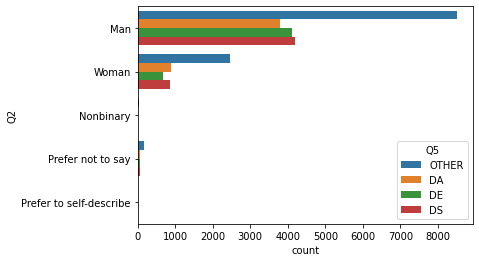

In [13]:
# Q2(성별) vs Q5
plt.subplots()
sns.countplot(y='Q2', hue='Q5', data=res)

In [14]:
# 상위 국가 top15 확인
res.Q3.value_counts()[:15].index

Index(['India', 'United States of America', 'Other', 'Japan', 'China',
       'Brazil', 'Russia', 'Nigeria',
       'United Kingdom of Great Britain and Northern Ireland', 'Pakistan',
       'Egypt', 'Germany', 'Spain', 'Indonesia', 'Turkey'],
      dtype='object')

In [15]:
# top15 상위 국가 데이터 추출
tmp = pd.DataFrame()
ls = res.Q3.value_counts()[:15].index
for i in ls:
  tmp = pd.concat([tmp, res.loc[res.Q3.str.contains(i)]])

tmp.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Q41,Q42
1,910,50-54,Man,India,Bachelor’s degree,OTHER,5-10 years,"Python,R",Python,Vim / Emacs,Colab Notebooks,A laptop,Google Cloud TPUs,2-5 times,"Matplotlib , Seaborn , Ggplot / ggplot2 , Shi...",5-10 years,"Scikit-learn , TensorFlow , Caret","Linear or Logistic Regression,Decision Trees o...","General purpose image/video tools (PIL, cv2, s...","Word embeddings/vectors (GLoVe, fastText, word...",Manufacturing/Fabrication,50-249 employees,3-4,No (we do not use ML methods),None of these activities are an important part...,"25,000-29,999",$100-$999,Google Cloud Platform (GCP),,Google Cloud Compute Engine,Google Cloud Storage (GCS),No / None,PostgreSQL,,None,,No / None,,No / None,"GitHub , Kaggle","Coursera,edX,Kaggle Learn Courses,DataCamp,Uda...","Local development environments (RStudio, Jupyt...","Email newsletters (Data Elixir, O'Reilly Data ..."
5,781,45-49,Man,India,Doctoral degree,OTHER,< 1 years,"Python,C,MATLAB",Python,"Spyder , MATLAB , Jupyter Notebook",Google Cloud Datalab,"A cloud computing platform (AWS, Azure, GCP, h...",None,Never,"Matplotlib , Seaborn , Ggplot / ggplot2",10-20 years,"Scikit-learn , PyTorch , LightGBM","Linear or Logistic Regression,Decision Trees o...",,,Academics/Education,50-249 employees,5-9,We use ML methods for generating insights (but...,Analyze and understand data to influence produ...,"30,000-39,999","$1000-$9,999",Microsoft Azure,,Microsoft Azure Virtual Machines,Microsoft Azure Data Lake Storage,Azure Machine Learning Studio,None,,Microsoft Power BI,,No / None,,Weights & Biases,I do not share my work publicly,"Kaggle Learn Courses,Udemy","Local development environments (RStudio, Jupyt...","Journal Publications (peer-reviewed journals, ..."
6,1020,25-29,Woman,India,I prefer not to answer,OTHER,< 1 years,Python,Python,"Jupyter (JupyterLab, Jupyter Notebooks, etc) ,...",Colab Notebooks,A laptop,Google Cloud TPUs,2-5 times,"Matplotlib , Seaborn , Ggplot / ggplot2",Under 1 year,"Scikit-learn , TensorFlow , Keras , PyTorch...","Linear or Logistic Regression,Decision Trees o...",,,,,,,,,,"Amazon Web Services (AWS) , Microsoft Azure ,...",,"Amazon Elastic Compute Cloud (EC2) , Microsof...",,"Amazon SageMaker , Azure Machine Learning Stu...",Microsoft Azure SQL Database,,Tableau,,Automation of full ML pipelines (e.g. Google C...,"Google Cloud AutoML , Azure Automated Machin...","Guild.ai , MLflow",,"Cloud-certification programs (direct from AWS,...","Local development environments (RStudio, Jupyt...","Email newsletters (Data Elixir, O'Reilly Data ..."
7,141,18-21,Woman,India,Some college/university study without earning ...,OTHER,1-3 years,"C++,Java,Javascript",Python,"Visual Studio , Visual Studio Code (VSCode) ,...","Kaggle Notebooks,Google Cloud Notebooks (AI P...",A laptop,None,Never,Geoplotlib,Under 1 year,Fast.ai,,,,,,,,,,,,,,,,,,,,,,,,,,
8,484,30-34,Man,India,Bachelor’s degree,DS,5-10 years,Python,Python,Jupyter Notebook,Kaggle Notebooks,A personal computer / desktop,Google Cloud TPUs,2-5 times,"Matplotlib , Plotly / Plotly Express",2-3 years,"Scikit-learn , TensorFlow , Keras","Decision Trees or Random Forests,Dense Neural ...","Image segmentation methods (U-Net, Mask R-CNN,...",,Computers/Technology,"10,000 or more employees",3-4,"We have well established ML methods (i.e., mod...",Build and/or run the data infrastructure that ...,"15,000-19,999",$1-$99,Google Cloud Platform (GCP),,Google Cloud Compute Engine,"Google Cloud Storage (GCS) , Google Cloud Fi...",Amazon SageMaker,MySQL,,None,,"Automated data augmentation (e.g. imgaug, albu...",Databricks AutoML,MLflow,"Plotly Dash , Kaggle","Coursera,Kaggle Learn Courses,Udemy,LinkedIn L...","Basic statistical software (Microsoft Excel, G...","Kaggle (notebooks, forums, etc),Course Forums ..."


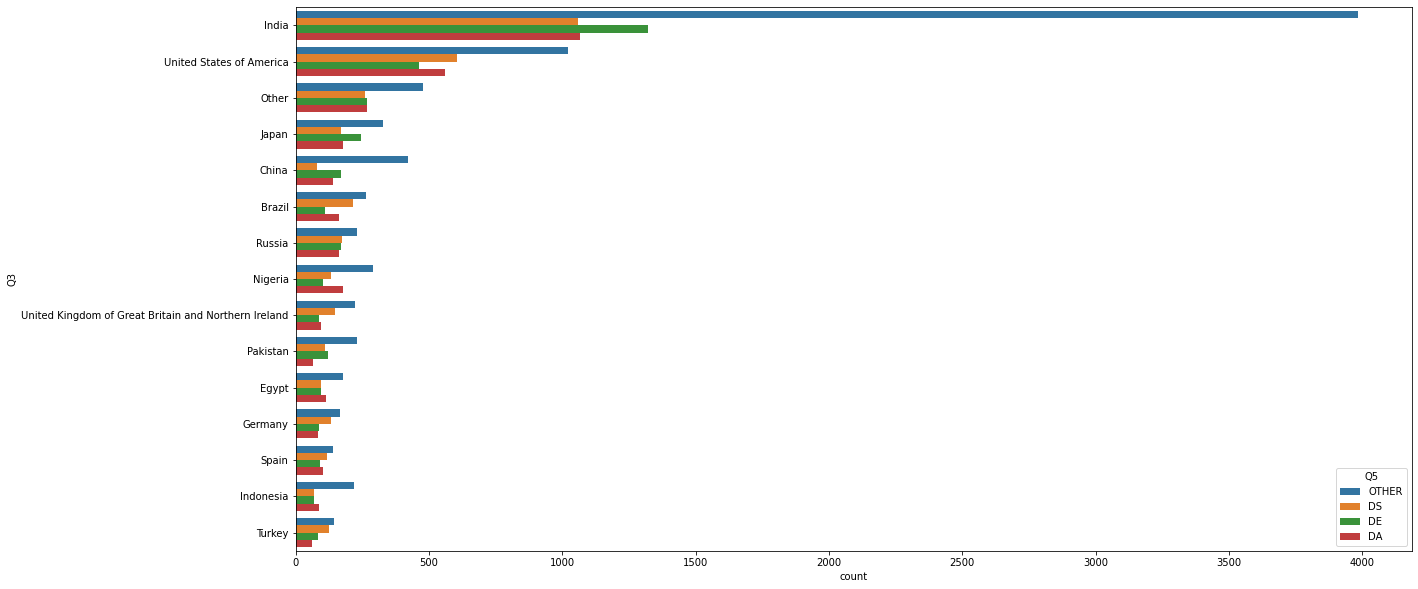

In [16]:
# Q3(Top 15 국가) vs Q5
plt.subplots(figsize=(20, 10))
sns.countplot(y = 'Q3', hue= 'Q5', data=tmp)

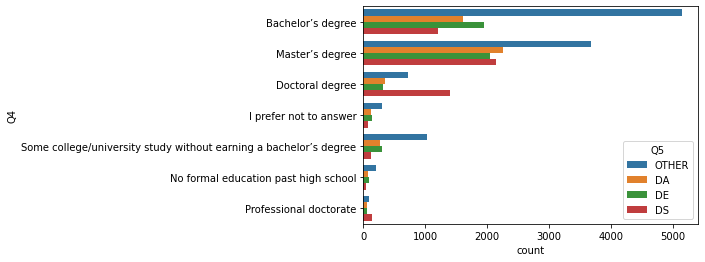

In [17]:
# Q4(학위) vs Q5
sns.countplot(y = 'Q4', hue= 'Q5', data=res)

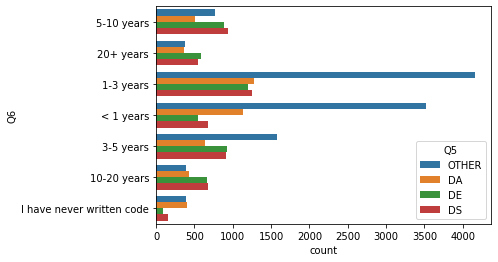

In [18]:
# Q6(코딩기간) vs Q5
sns.countplot(y = 'Q6', hue= 'Q5', data=res)

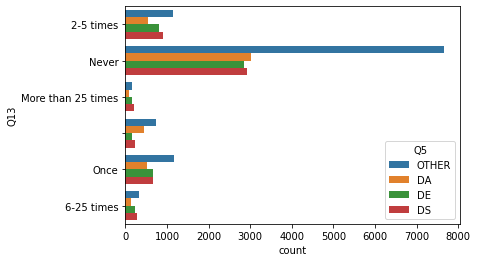

In [19]:
# Q13(TPU) vs Q5
sns.countplot(y = 'Q13', hue= 'Q5', data=res)

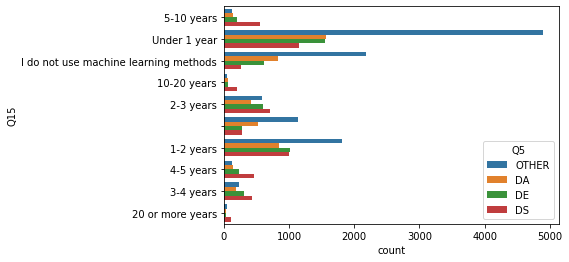

In [20]:
# Q15(ML 배운기간) vs Q5
sns.countplot(y= 'Q15', hue= 'Q5', data=res)

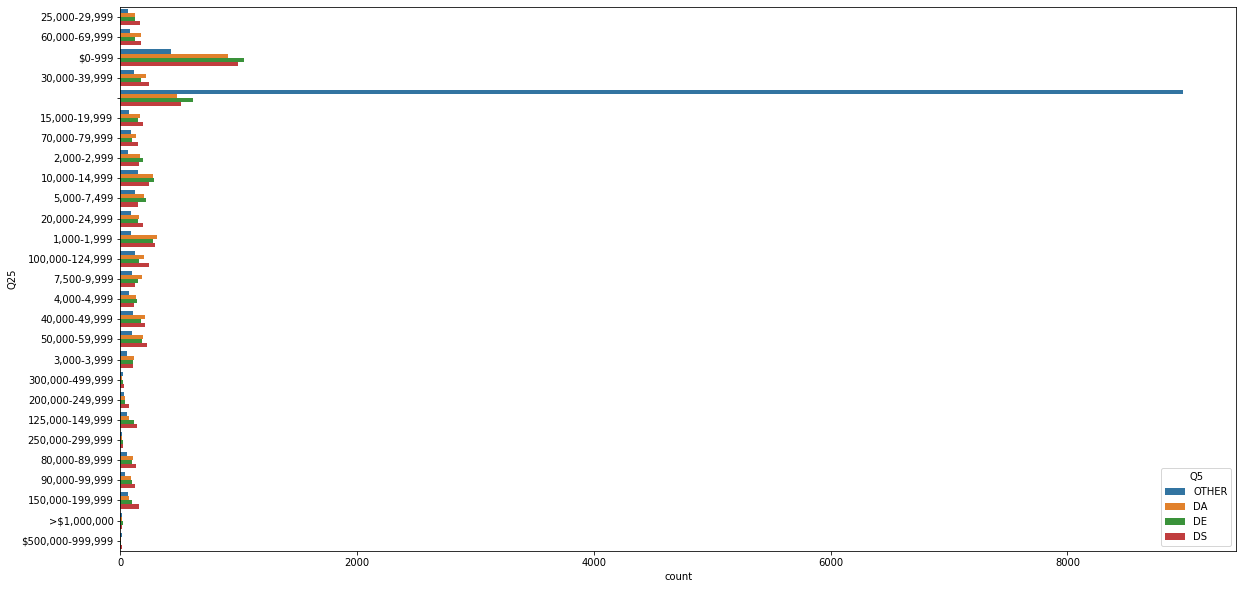

In [21]:
# Q25(급여) vs Q5
plt.subplots(figsize=(20, 10))
sns.countplot(y = 'Q25', hue= 'Q5', data=res)

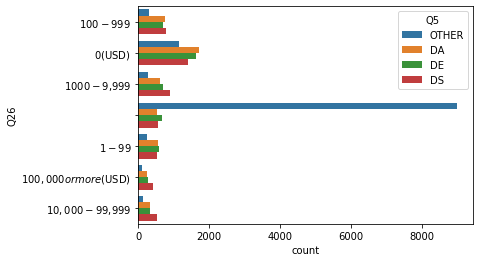

In [22]:
# Q26(ML/cloud 비용) vs Q5
sns.countplot(y = 'Q26', hue= 'Q5', data=res)

# 응답결과 군집으로 나누어보기

- 이건 그냥.. 제가 궁금해서 한번 해보았어요! 전부 label encoding으로 인코딩해서 KMeans 사용해보기!
- 그닥 유의미한 결과는 아직 보이지 않네요 ㅎㅎ 그냥 별걸 다 해보는구나..하고 넘어가주세요 :)

In [23]:
response.head(3)

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_Part_12,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,...,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_Part_12,Q34_B_Part_13,Q34_B_Part_14,Q34_B_Part_15,Q34_B_Part_16,Q34_B_OTHER,Q36_B_Part_1,Q36_B_Part_2,Q36_B_Part_3,Q36_B_Part_4,Q36_B_Part_5,Q36_B_Part_6,Q36_B_Part_7,Q36_B_OTHER,Q37_B_Part_1,Q37_B_Part_2,Q37_B_Part_3,Q37_B_Part_4,Q37_B_Part_5,Q37_B_Part_6,Q37_B_Part_7,Q37_B_OTHER,Q38_B_Part_1,Q38_B_Part_2,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming language would you recommend ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool

In [24]:
df = response.copy()
df.drop(df.columns[0], axis=1, inplace=True) ## 소요시간 컬럼 삭제
df.drop(0, inplace=True) ## 0번 인덱스 삭제
df.head(3)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_Part_12,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,...,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_Part_12,Q34_B_Part_13,Q34_B_Part_14,Q34_B_Part_15,Q34_B_Part_16,Q34_B_OTHER,Q36_B_Part_1,Q36_B_Part_2,Q36_B_Part_3,Q36_B_Part_4,Q36_B_Part_5,Q36_B_Part_6,Q36_B_Part_7,Q36_B_OTHER,Q37_B_Part_1,Q37_B_Part_2,Q37_B_Part_3,Q37_B_Part_4,Q37_B_Part_5,Q37_B_Part_6,Q37_B_Part_7,Q37_B_OTHER,Q38_B_Part_1,Q38_B_Part_2,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
1,50-54,Man,India,Bachelor’s degree,Other,5-10 years,Python,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Python,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vim / Emacs,NaN,NaN,NaN,NaN,NaN,Colab Notebooks,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,NaN,NaN,SQL,C,C++,Java,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Python,NaN,NaN,NaN,NaN,NaN,NaN,Notepad++,NaN,NaN,NaN,Jupyter Notebook,NaN,NaN,Kaggle Notebooks,Colab Notebooks,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Qlik,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Automated model selection (e.g. auto-sklearn, ...",NaN,NaN,NaN,NaN,NaN,Google Cloud AutoML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
3,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,Python,NaN,NaN,NaN,C++,Java,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Python,NaN,NaN,NaN,NaN,PyCharm,NaN,NaN,NaN,NaN,NaN,Jupyter Notebook,NaN,Other,Kaggle Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Automated model selection (e.g. auto-sklearn, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DataRobot AutoML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# 전체 다 출력
pd.set_option('display.max_seq_items', None)

In [26]:
# 질문이 하나로 통합되어 있는 컬럼 확인
for i in range(1, 43):
  tmp = 'Q'+str(i)
  print(tmp, len(df.columns[df.columns.str.contains(tmp)])) ##Q1부터 4까지는 Q10..Q20 등 모두 포함되어 있음!

Q1 82
Q2 50
Q3 181
Q4 26
Q5 1
Q6 1
Q7 13
Q8 1
Q9 13
Q10 17
Q11 1
Q12 6
Q13 1
Q14 12
Q15 1
Q16 18
Q17 12
Q18 7
Q19 6
Q20 1
Q21 1
Q22 1
Q23 1
Q24 8
Q25 1
Q26 1
Q27 24
Q28 1
Q29 10
Q30 16
Q31 20
Q32 42
Q33 1
Q34 34
Q35 1
Q36 16
Q37 16
Q38 24
Q39 10
Q40 12
Q41 1
Q42 12


In [27]:
# 질문 하나인 컬럼
ls = [1, 2, 3, 4, 5, 6, 8, 11, 13, 15, 20, 21, 22, 23, 25, 26, 28, 33, 35, 41]
new_ls = []
for i in ls:
  new_ls.append('Q'+str(i))

# 질문 두개 이상인 컬럼
import collections
new_ls1 = list(collections.Counter(df.columns) - collections.Counter(new_ls))

In [28]:
# 인코딩
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
for i in new_ls:
  df[i] = df[i].fillna('0')
  df[i] = enc.fit_transform(df[i])

for i in new_ls1:
  df[i] = df[i].fillna(0) ## 0과 1로 구분
  df[i] = df[i].apply(bool).apply(int)

In [29]:
df.head(3)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_Part_12,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,...,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_Part_12,Q34_B_Part_13,Q34_B_Part_14,Q34_B_Part_15,Q34_B_Part_16,Q34_B_OTHER,Q36_B_Part_1,Q36_B_Part_2,Q36_B_Part_3,Q36_B_Part_4,Q36_B_Part_5,Q36_B_Part_6,Q36_B_Part_7,Q36_B_OTHER,Q37_B_Part_1,Q37_B_Part_2,Q37_B_Part_3,Q37_B_Part_4,Q37_B_Part_5,Q37_B_Part_6,Q37_B_Part_7,Q37_B_OTHER,Q38_B_Part_1,Q38_B_Part_2,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
1,7,0,23,0,8,4,1,1,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,24,3,10,2,0,0,1,1,1,1,0,0,0,0,0,0,0,10,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,0,41,3,12,0,1,0,0,0,1,1,0,0,0,0,0,0,0,10,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


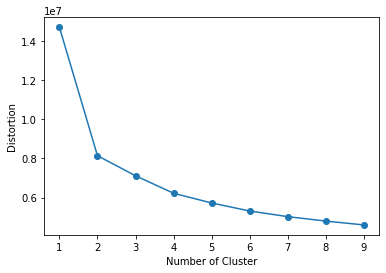

In [31]:
# KMeans의 K 확인
from sklearn.cluster import KMeans
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in range(1, 10):
        km = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)

    plt.plot(range(1, 10), distortions, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distortion')
    plt.show()

visualize_elbowmethod(df)

In [32]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# standardscaler
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
# Kmeans, K=5
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10, max_iter=300)
kmeans.fit_transform(scaled)

array([[19.93938174, 19.57973962, 17.20206528, 28.02950601, 21.90594278],
       [14.95178108, 14.79882889, 16.37817966, 23.31530154, 22.903329  ],
       [18.29980913, 18.56539664, 19.20225557, 25.44074121, 25.08457542],
       ...,
       [22.417451  , 24.29502972, 26.33087116, 23.03263723, 31.14558389],
       [11.56786265,  7.8563011 ,  9.9021622 , 22.87271413, 19.28767326],
       [15.69005833, 12.15911828, 15.30973486, 24.8887439 , 22.70768621]])

In [33]:
# label 추가
df['cluster'] = kmeans.labels_
df.head(2)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_Part_12,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,...,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_Part_12,Q34_B_Part_13,Q34_B_Part_14,Q34_B_Part_15,Q34_B_Part_16,Q34_B_OTHER,Q36_B_Part_1,Q36_B_Part_2,Q36_B_Part_3,Q36_B_Part_4,Q36_B_Part_5,Q36_B_Part_6,Q36_B_Part_7,Q36_B_OTHER,Q37_B_Part_1,Q37_B_Part_2,Q37_B_Part_3,Q37_B_Part_4,Q37_B_Part_5,Q37_B_Part_6,Q37_B_Part_7,Q37_B_OTHER,Q38_B_Part_1,Q38_B_Part_2,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER,cluster
1,7,0,23,0,8,4,1,1,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,7,0,24,3,10,2,0,0,1,1,1,1,0,0,0,0,0,0,0,10,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


<Figure size 432x288 with 0 Axes>

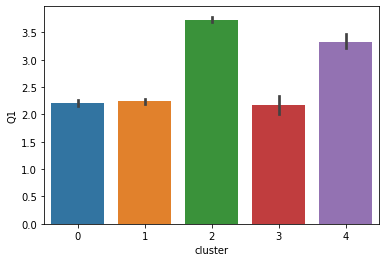

<Figure size 432x288 with 0 Axes>

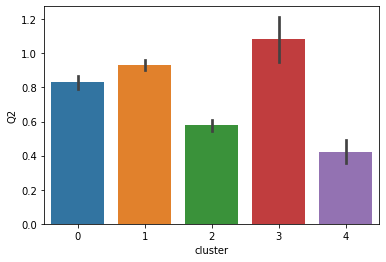

<Figure size 432x288 with 0 Axes>

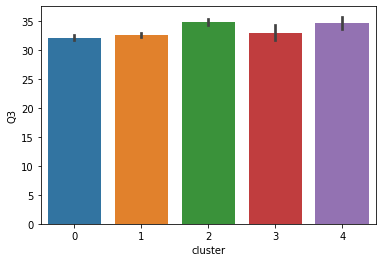

<Figure size 432x288 with 0 Axes>

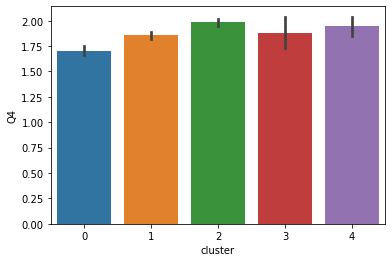

<Figure size 432x288 with 0 Axes>

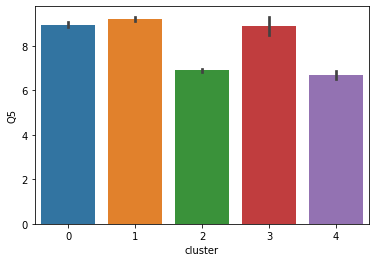

<Figure size 432x288 with 0 Axes>

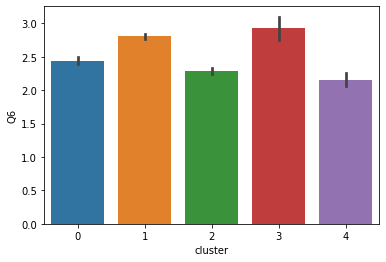

<Figure size 432x288 with 0 Axes>

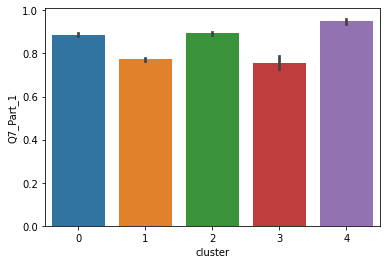

<Figure size 432x288 with 0 Axes>

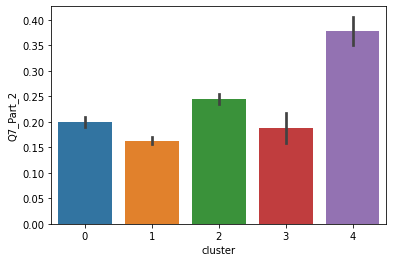

<Figure size 432x288 with 0 Axes>

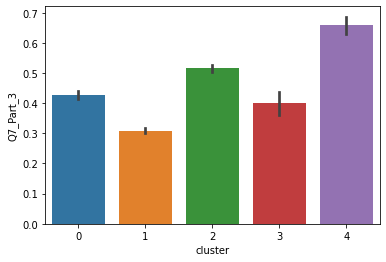

<Figure size 432x288 with 0 Axes>

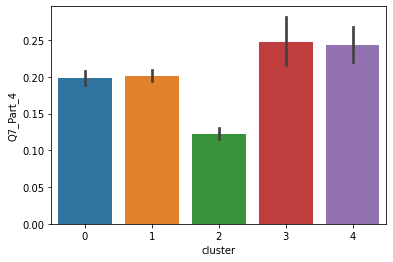

<Figure size 432x288 with 0 Axes>

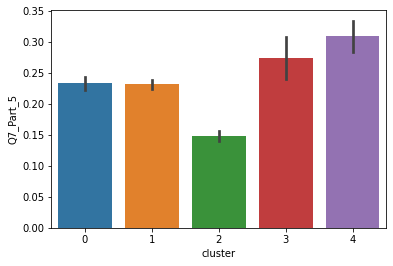

<Figure size 432x288 with 0 Axes>

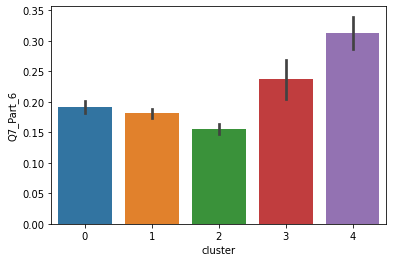

<Figure size 432x288 with 0 Axes>

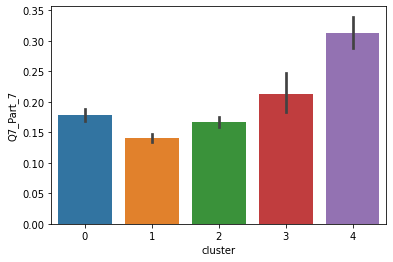

<Figure size 432x288 with 0 Axes>

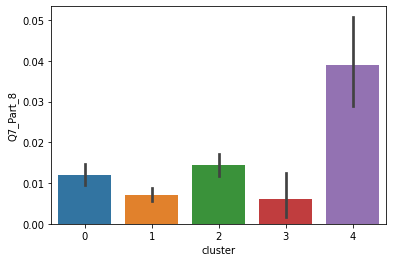

<Figure size 432x288 with 0 Axes>

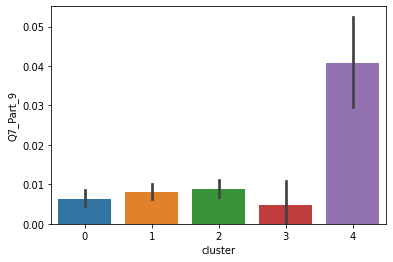

<Figure size 432x288 with 0 Axes>

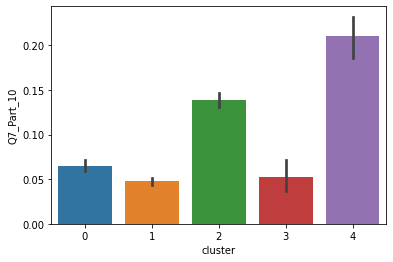

<Figure size 432x288 with 0 Axes>

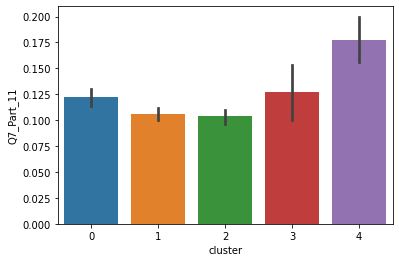

<Figure size 432x288 with 0 Axes>

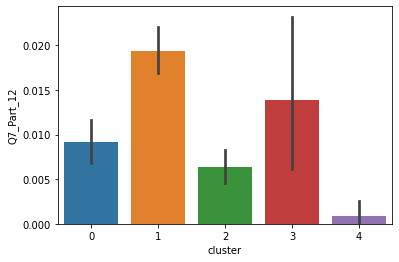

<Figure size 432x288 with 0 Axes>

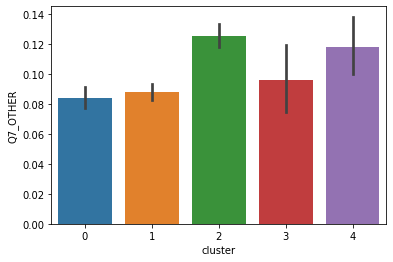

<Figure size 432x288 with 0 Axes>

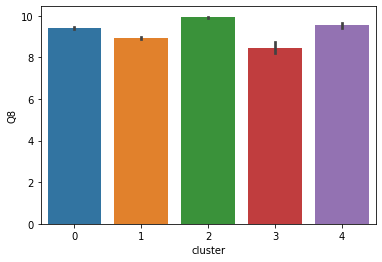

<Figure size 432x288 with 0 Axes>

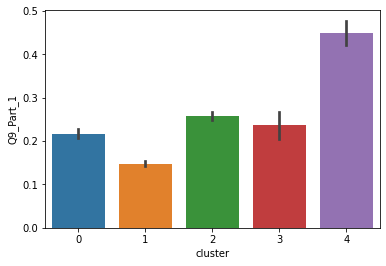

<Figure size 432x288 with 0 Axes>

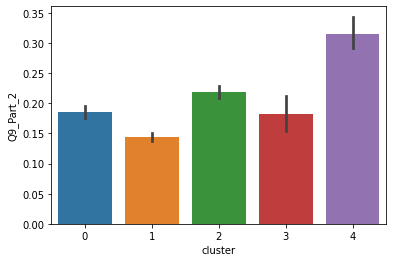

<Figure size 432x288 with 0 Axes>

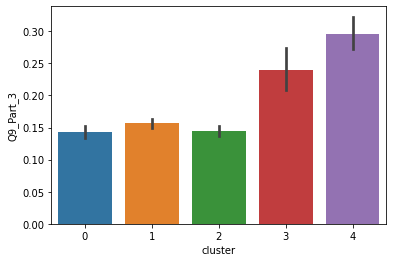

<Figure size 432x288 with 0 Axes>

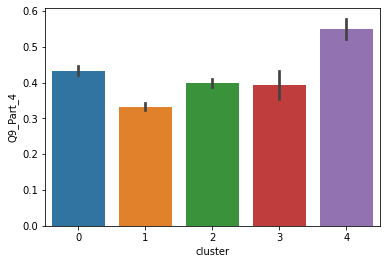

<Figure size 432x288 with 0 Axes>

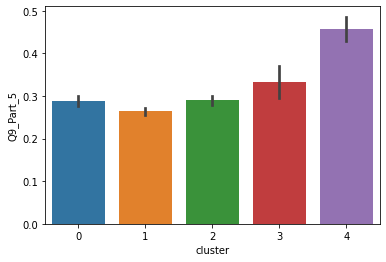

<Figure size 432x288 with 0 Axes>

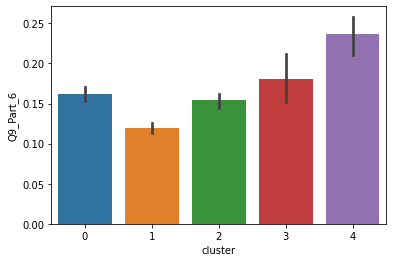

<Figure size 432x288 with 0 Axes>

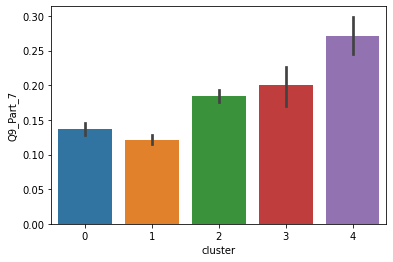

<Figure size 432x288 with 0 Axes>

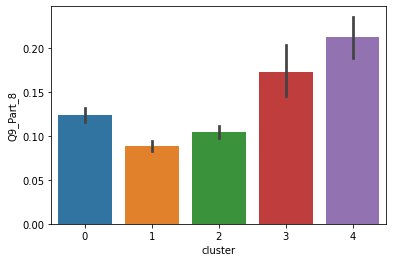

<Figure size 432x288 with 0 Axes>

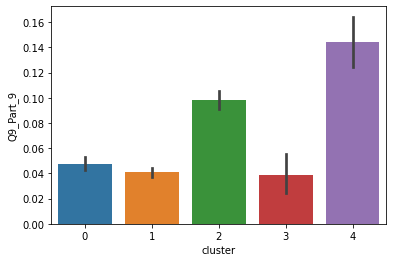

<Figure size 432x288 with 0 Axes>

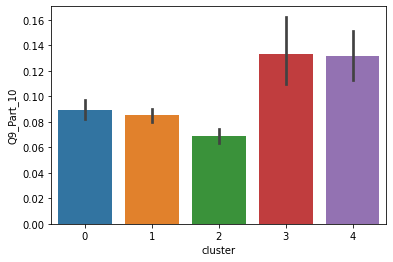

<Figure size 432x288 with 0 Axes>

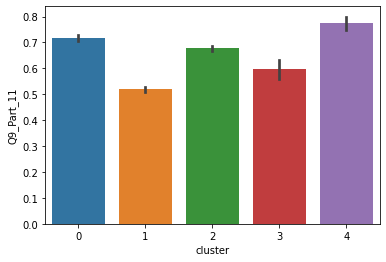

<Figure size 432x288 with 0 Axes>

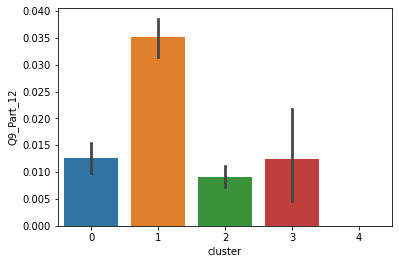

<Figure size 432x288 with 0 Axes>

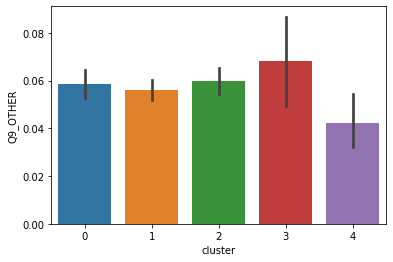

<Figure size 432x288 with 0 Axes>

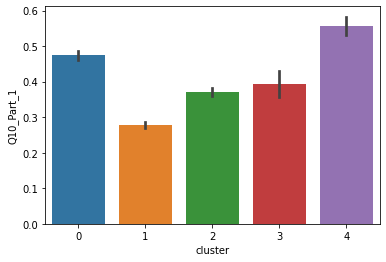

<Figure size 432x288 with 0 Axes>

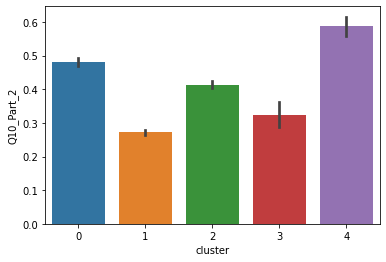

<Figure size 432x288 with 0 Axes>

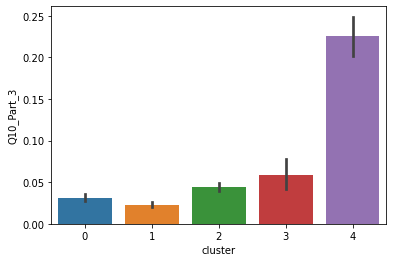

<Figure size 432x288 with 0 Axes>

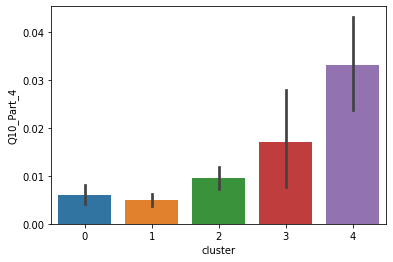

<Figure size 432x288 with 0 Axes>

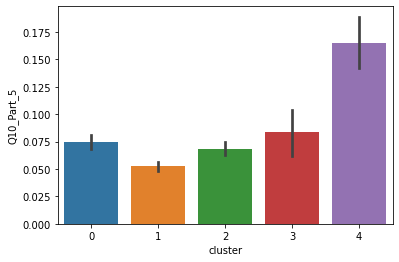

<Figure size 432x288 with 0 Axes>

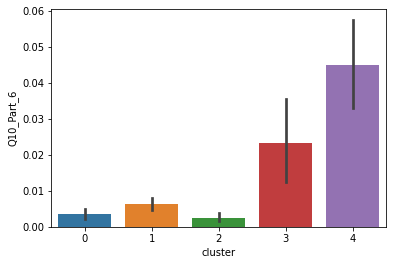

<Figure size 432x288 with 0 Axes>

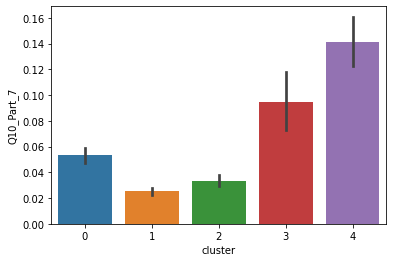

<Figure size 432x288 with 0 Axes>

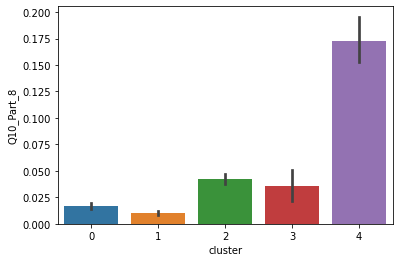

<Figure size 432x288 with 0 Axes>

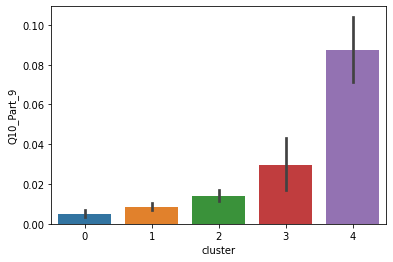

<Figure size 432x288 with 0 Axes>

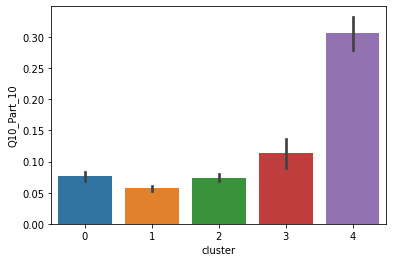

<Figure size 432x288 with 0 Axes>

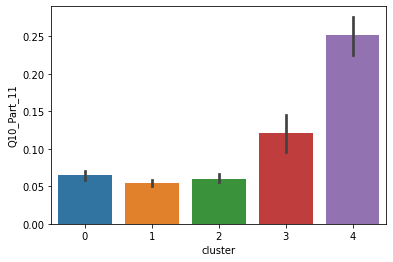

<Figure size 432x288 with 0 Axes>

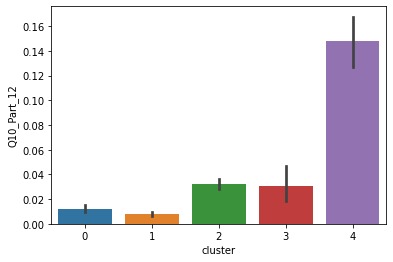

<Figure size 432x288 with 0 Axes>

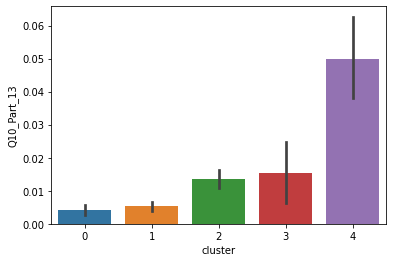

<Figure size 432x288 with 0 Axes>

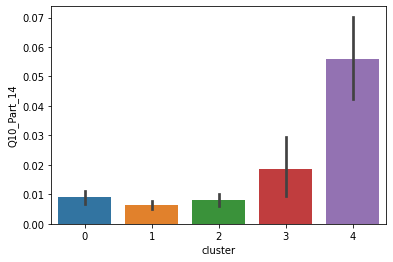

<Figure size 432x288 with 0 Axes>

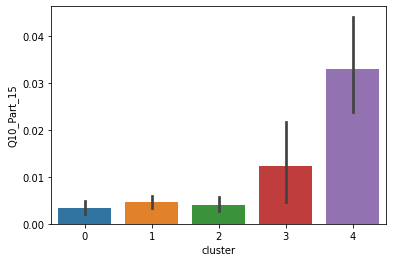

<Figure size 432x288 with 0 Axes>

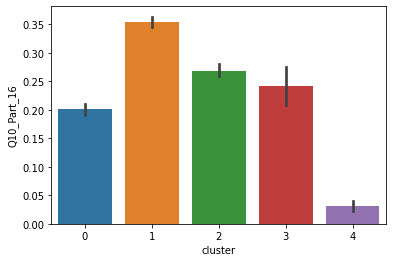

<Figure size 432x288 with 0 Axes>

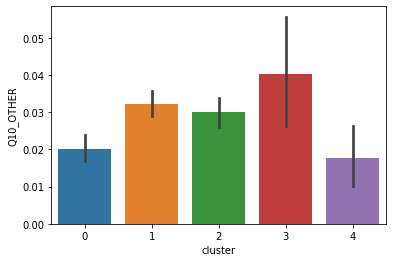

<Figure size 432x288 with 0 Axes>

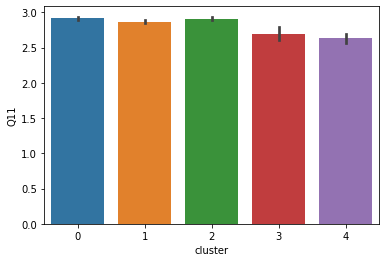

<Figure size 432x288 with 0 Axes>

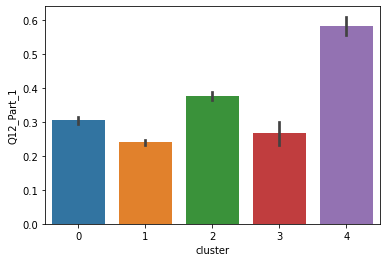

<Figure size 432x288 with 0 Axes>

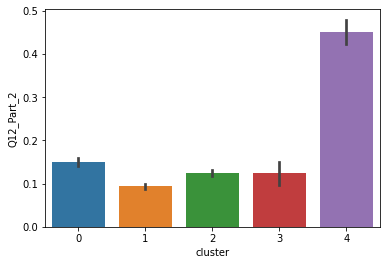

<Figure size 432x288 with 0 Axes>

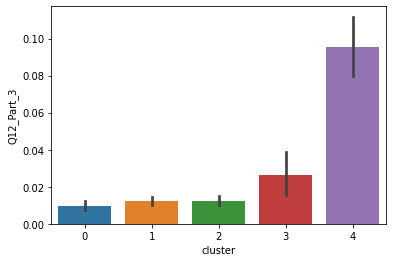

<Figure size 432x288 with 0 Axes>

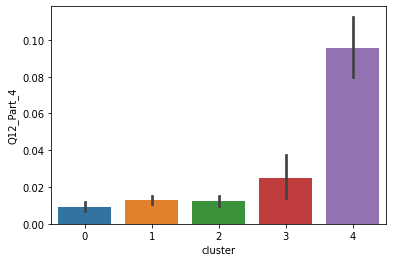

<Figure size 432x288 with 0 Axes>

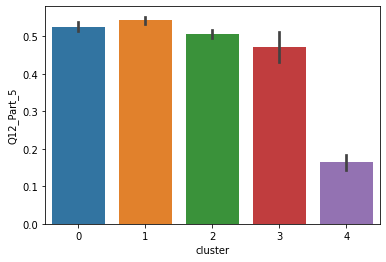

<Figure size 432x288 with 0 Axes>

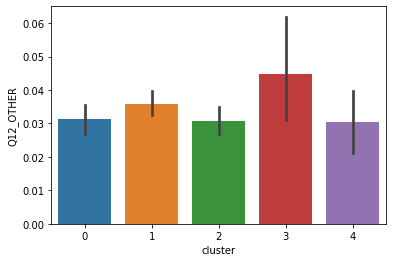

<Figure size 432x288 with 0 Axes>

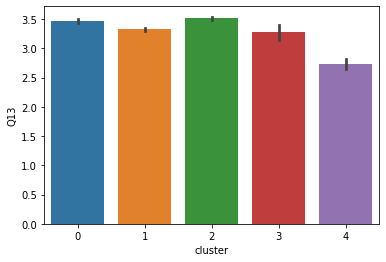

<Figure size 432x288 with 0 Axes>

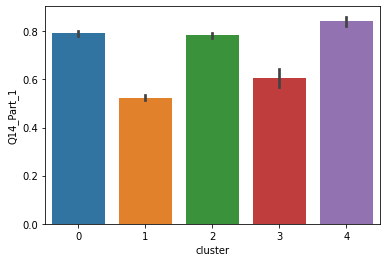

<Figure size 432x288 with 0 Axes>

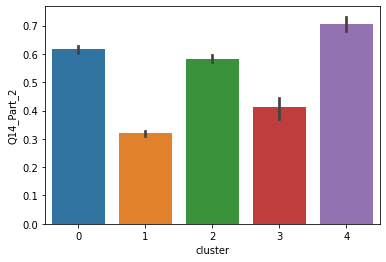

<Figure size 432x288 with 0 Axes>

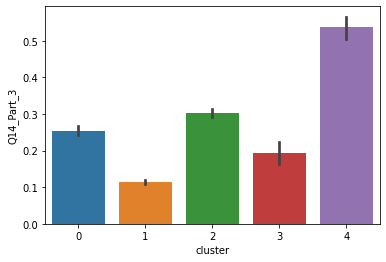

<Figure size 432x288 with 0 Axes>

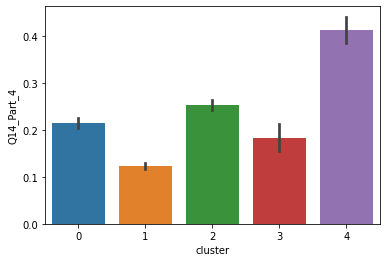

<Figure size 432x288 with 0 Axes>

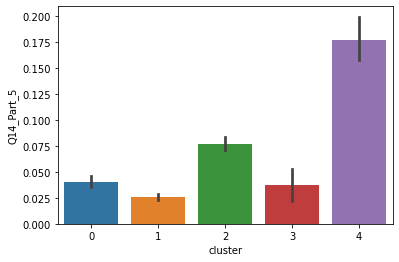

<Figure size 432x288 with 0 Axes>

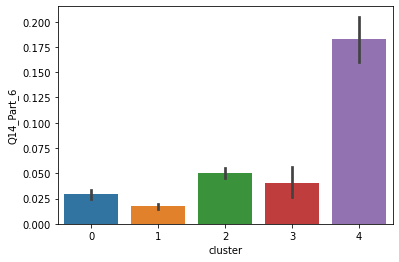

<Figure size 432x288 with 0 Axes>

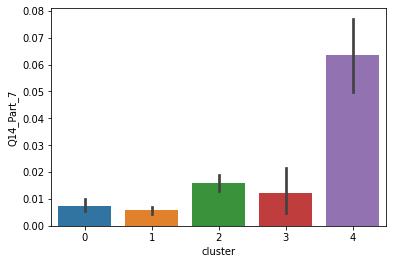

<Figure size 432x288 with 0 Axes>

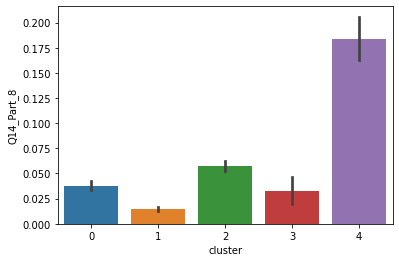

<Figure size 432x288 with 0 Axes>

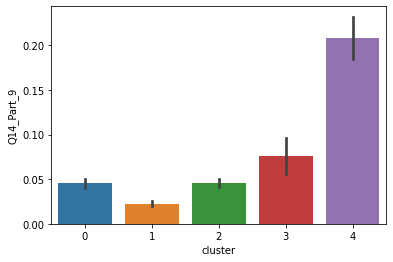

<Figure size 432x288 with 0 Axes>

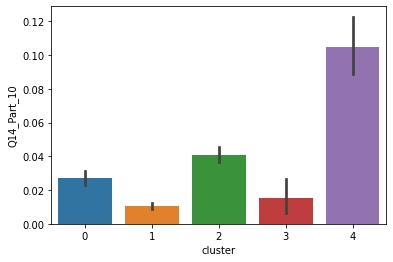

<Figure size 432x288 with 0 Axes>

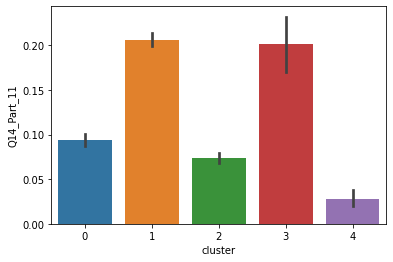

<Figure size 432x288 with 0 Axes>

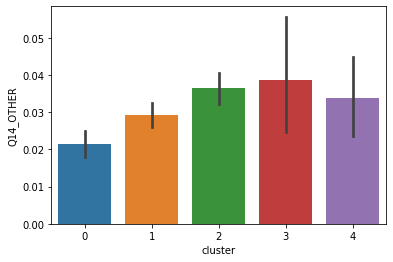

<Figure size 432x288 with 0 Axes>

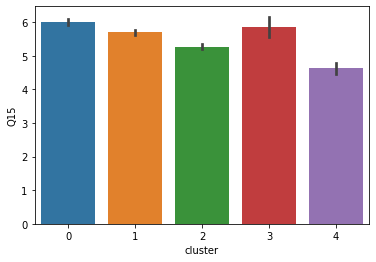

<Figure size 432x288 with 0 Axes>

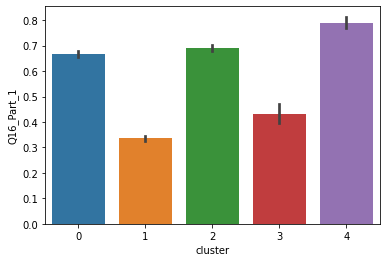

<Figure size 432x288 with 0 Axes>

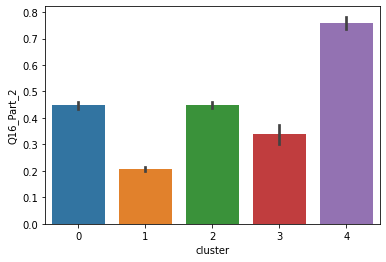

<Figure size 432x288 with 0 Axes>

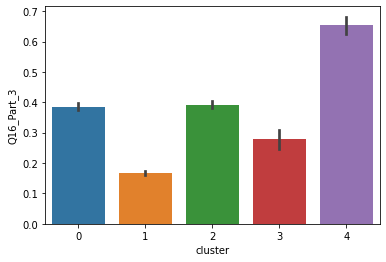

<Figure size 432x288 with 0 Axes>

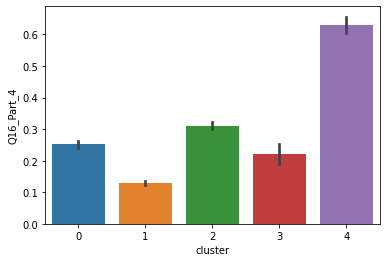

<Figure size 432x288 with 0 Axes>

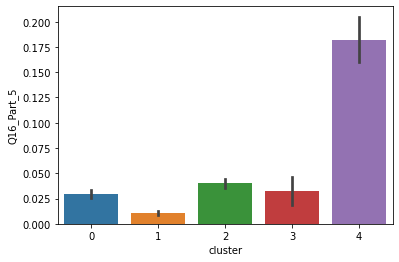

<Figure size 432x288 with 0 Axes>

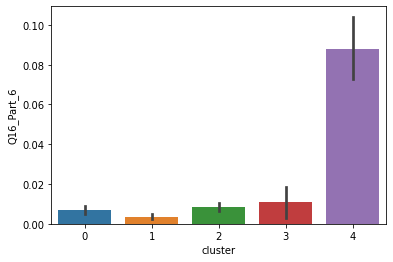

<Figure size 432x288 with 0 Axes>

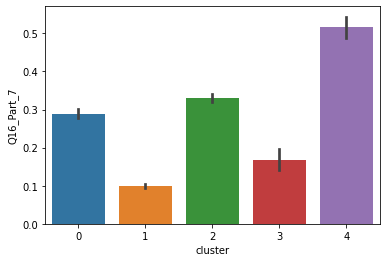

<Figure size 432x288 with 0 Axes>

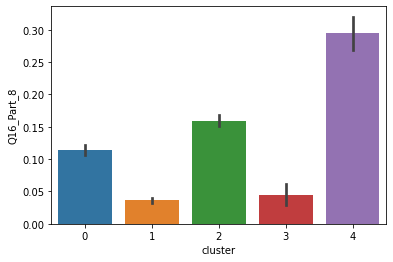

<Figure size 432x288 with 0 Axes>

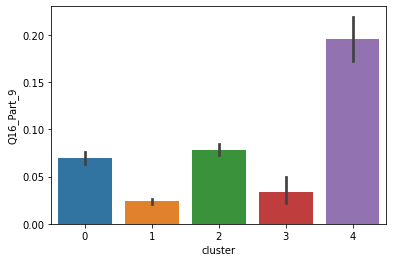

<Figure size 432x288 with 0 Axes>

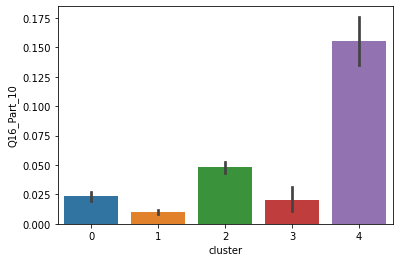

<Figure size 432x288 with 0 Axes>

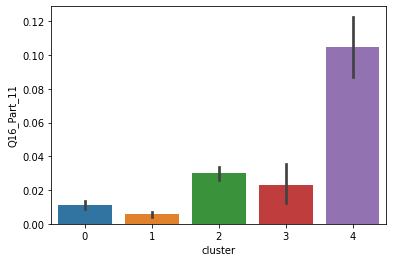

<Figure size 432x288 with 0 Axes>

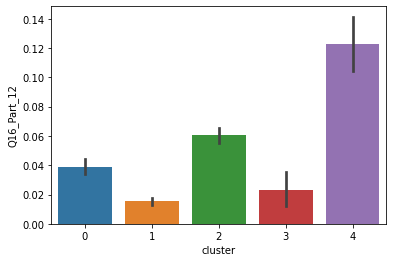

<Figure size 432x288 with 0 Axes>

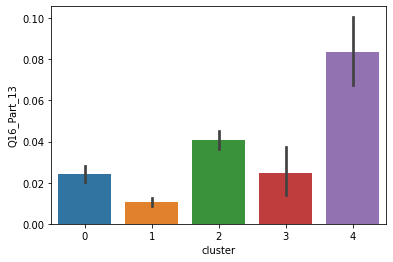

<Figure size 432x288 with 0 Axes>

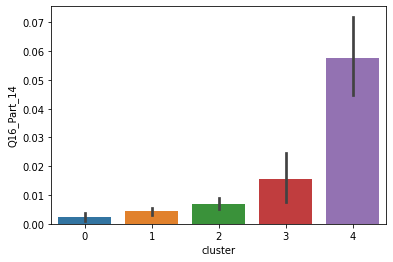

<Figure size 432x288 with 0 Axes>

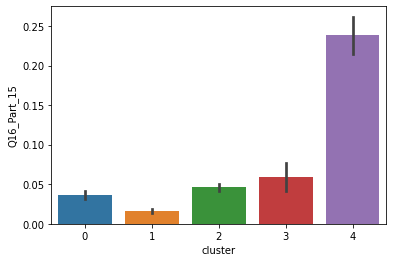

<Figure size 432x288 with 0 Axes>

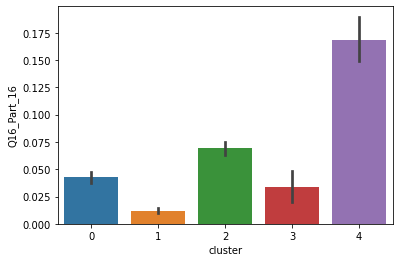

<Figure size 432x288 with 0 Axes>

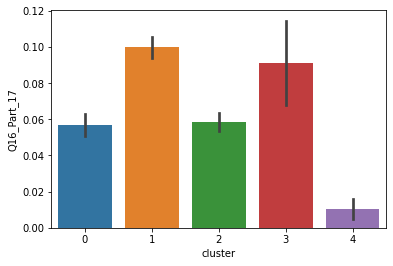

<Figure size 432x288 with 0 Axes>

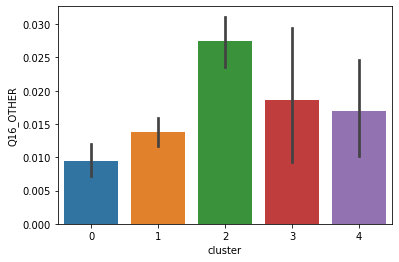

<Figure size 432x288 with 0 Axes>

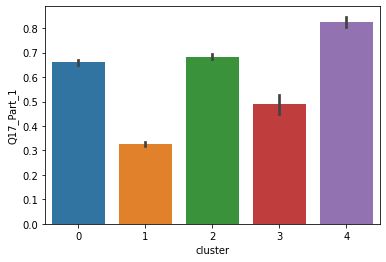

<Figure size 432x288 with 0 Axes>

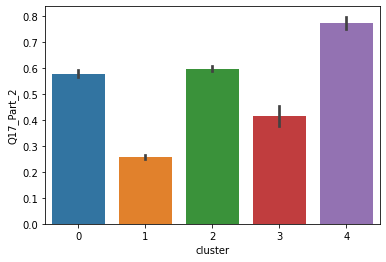

<Figure size 432x288 with 0 Axes>

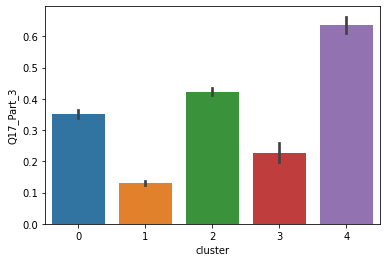

<Figure size 432x288 with 0 Axes>

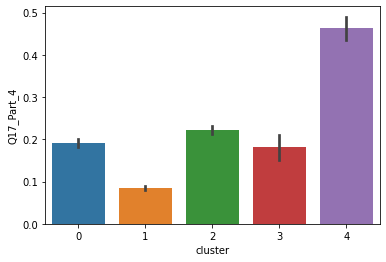

<Figure size 432x288 with 0 Axes>

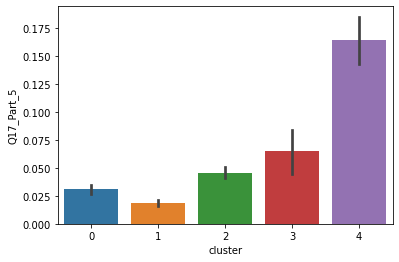

<Figure size 432x288 with 0 Axes>

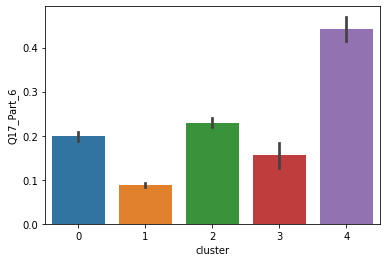

<Figure size 432x288 with 0 Axes>

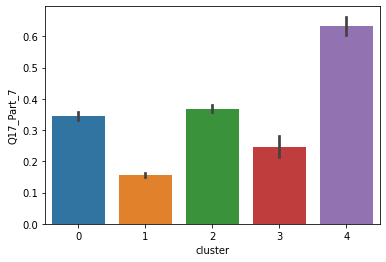

<Figure size 432x288 with 0 Axes>

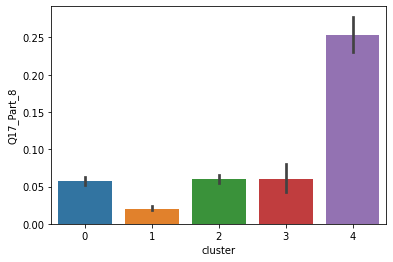

<Figure size 432x288 with 0 Axes>

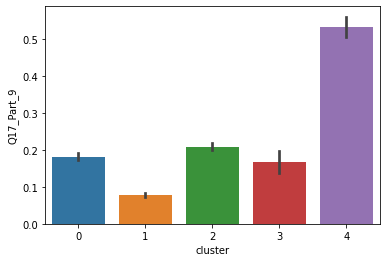

<Figure size 432x288 with 0 Axes>

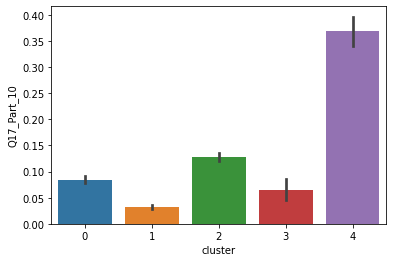

<Figure size 432x288 with 0 Axes>

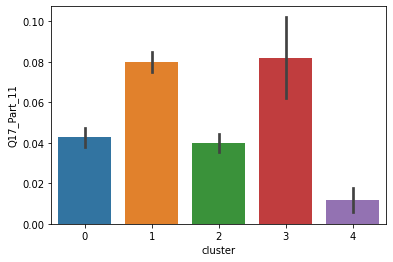

<Figure size 432x288 with 0 Axes>

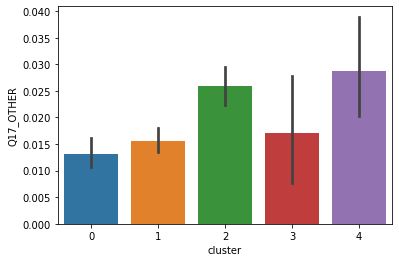

<Figure size 432x288 with 0 Axes>

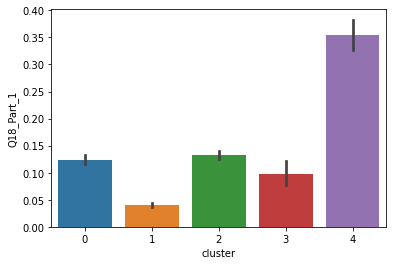

<Figure size 432x288 with 0 Axes>

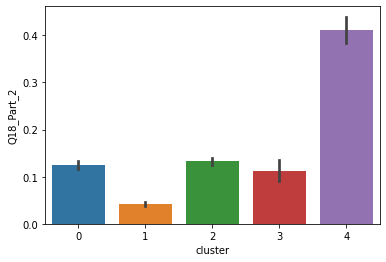

<Figure size 432x288 with 0 Axes>

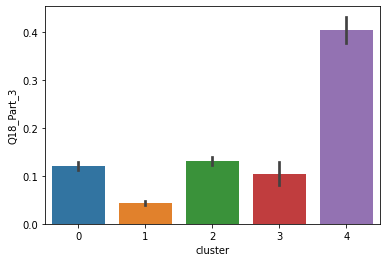

<Figure size 432x288 with 0 Axes>

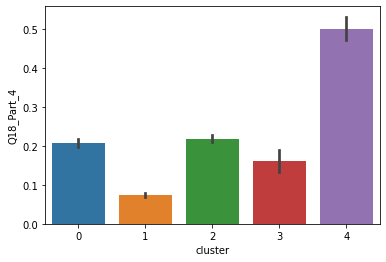

<Figure size 432x288 with 0 Axes>

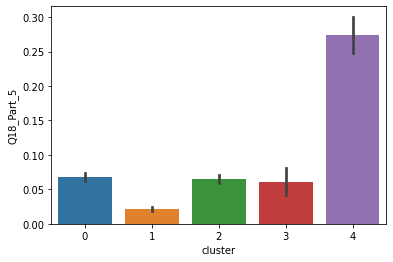

<Figure size 432x288 with 0 Axes>

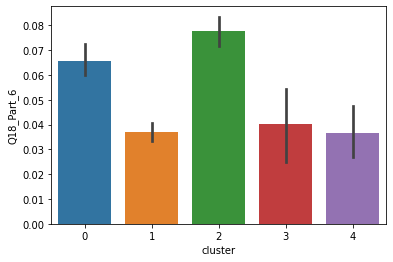

<Figure size 432x288 with 0 Axes>

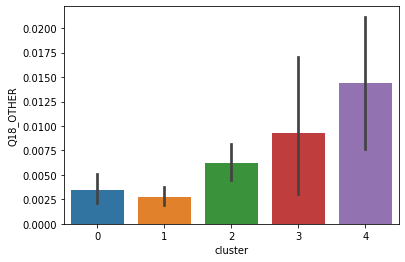

<Figure size 432x288 with 0 Axes>

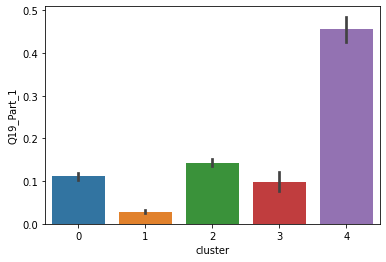

<Figure size 432x288 with 0 Axes>

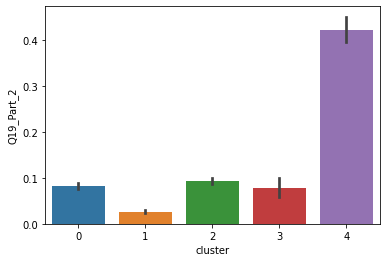

<Figure size 432x288 with 0 Axes>

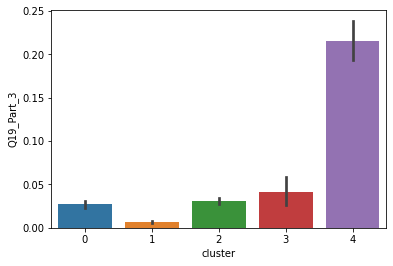

<Figure size 432x288 with 0 Axes>

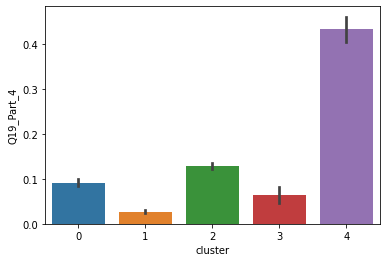

<Figure size 432x288 with 0 Axes>

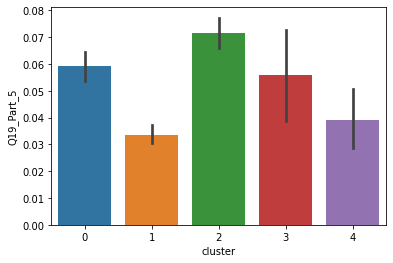

<Figure size 432x288 with 0 Axes>

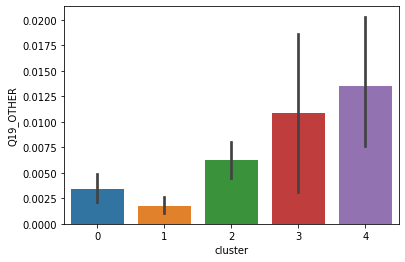

<Figure size 432x288 with 0 Axes>

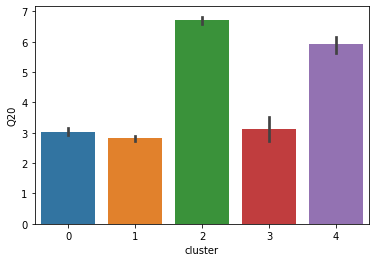

<Figure size 432x288 with 0 Axes>

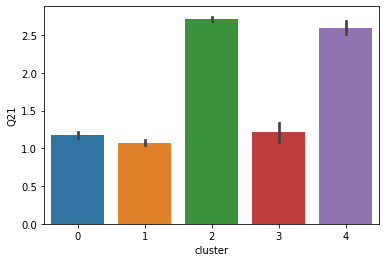

<Figure size 432x288 with 0 Axes>

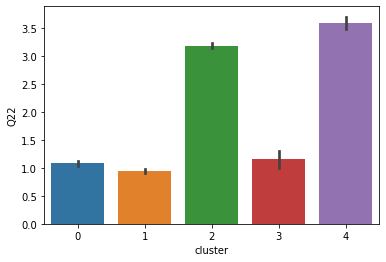

<Figure size 432x288 with 0 Axes>

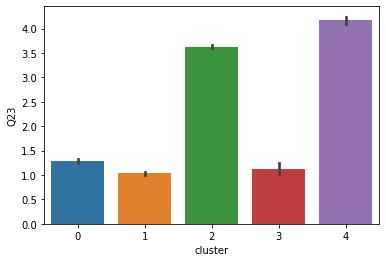

<Figure size 432x288 with 0 Axes>

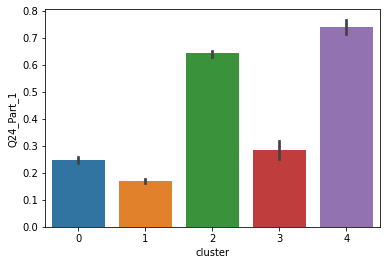

<Figure size 432x288 with 0 Axes>

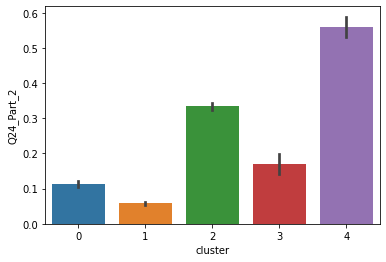

<Figure size 432x288 with 0 Axes>

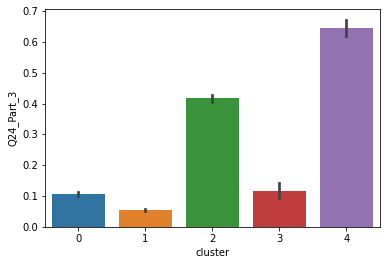

<Figure size 432x288 with 0 Axes>

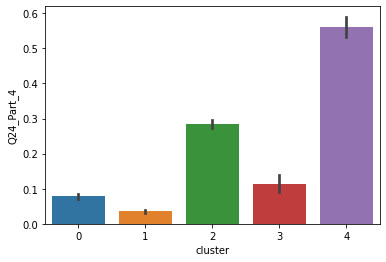

<Figure size 432x288 with 0 Axes>

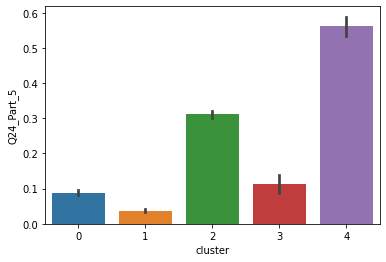

<Figure size 432x288 with 0 Axes>

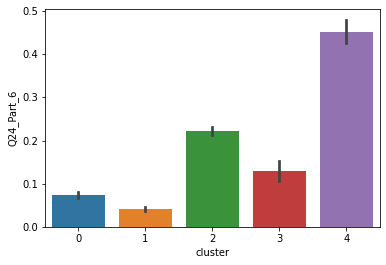

<Figure size 432x288 with 0 Axes>

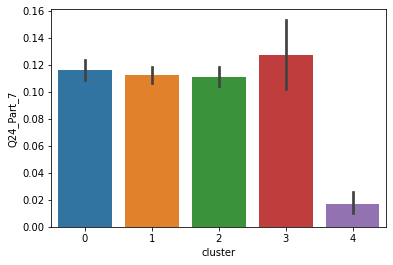

<Figure size 432x288 with 0 Axes>

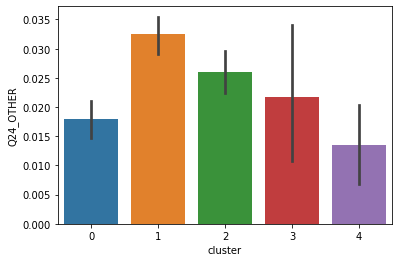

<Figure size 432x288 with 0 Axes>

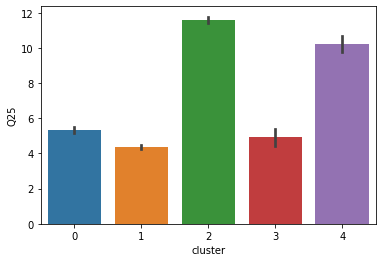

<Figure size 432x288 with 0 Axes>

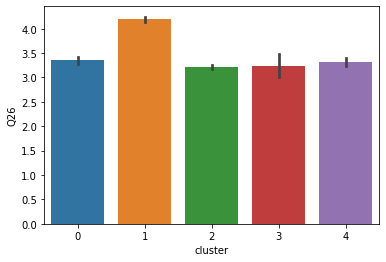

<Figure size 432x288 with 0 Axes>

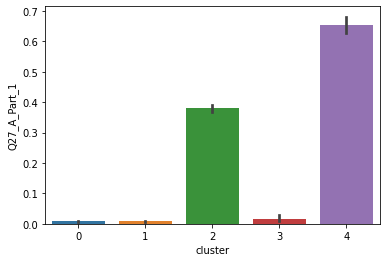

<Figure size 432x288 with 0 Axes>

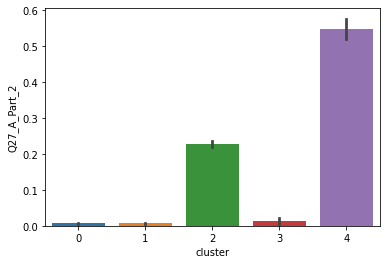

<Figure size 432x288 with 0 Axes>

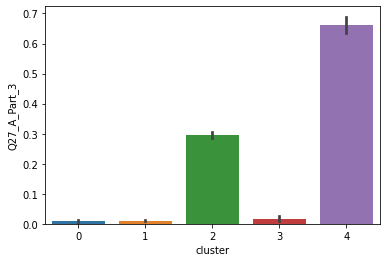

<Figure size 432x288 with 0 Axes>

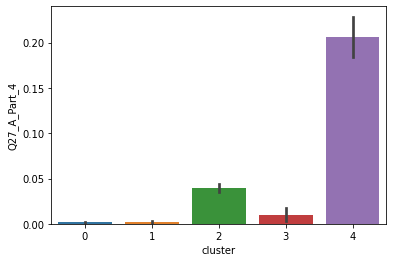

<Figure size 432x288 with 0 Axes>

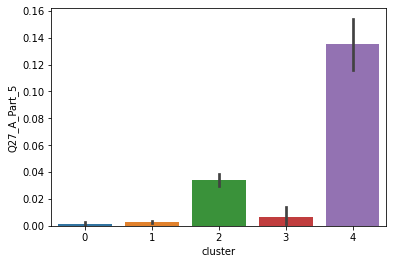

<Figure size 432x288 with 0 Axes>

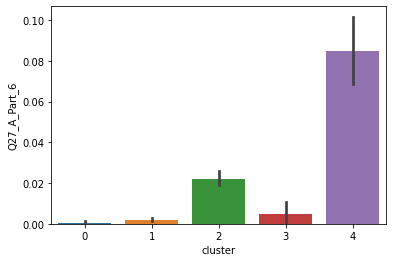

<Figure size 432x288 with 0 Axes>

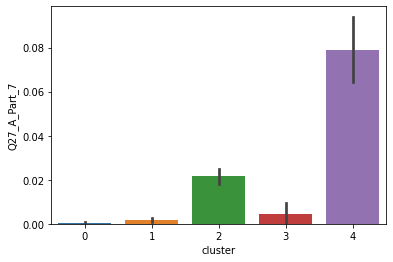

<Figure size 432x288 with 0 Axes>

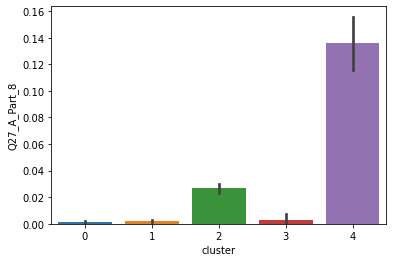

<Figure size 432x288 with 0 Axes>

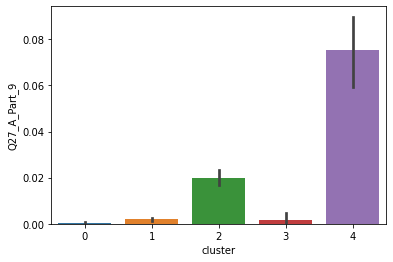

<Figure size 432x288 with 0 Axes>

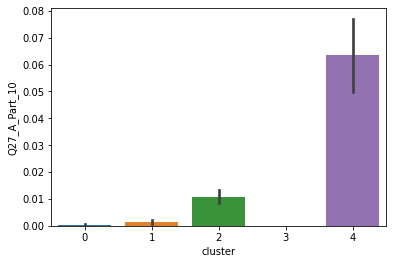

<Figure size 432x288 with 0 Axes>

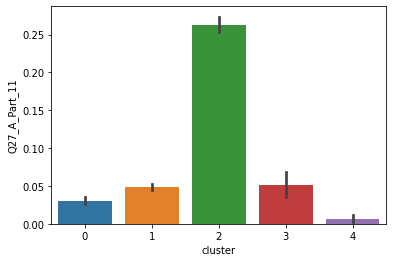

<Figure size 432x288 with 0 Axes>

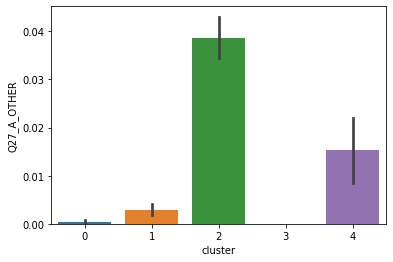

<Figure size 432x288 with 0 Axes>

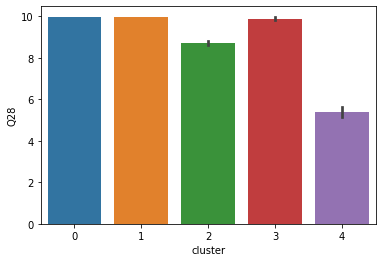

<Figure size 432x288 with 0 Axes>

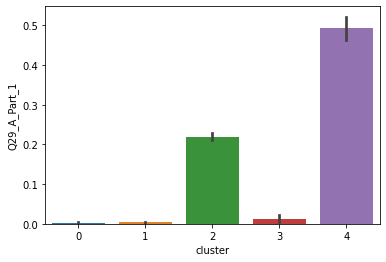

<Figure size 432x288 with 0 Axes>

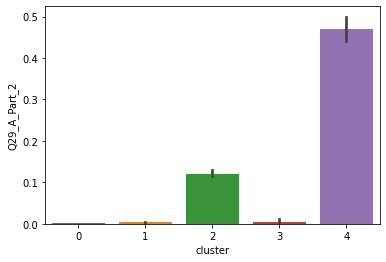

<Figure size 432x288 with 0 Axes>

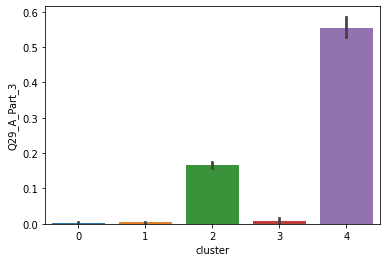

<Figure size 432x288 with 0 Axes>

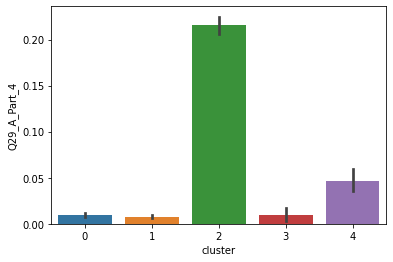

<Figure size 432x288 with 0 Axes>

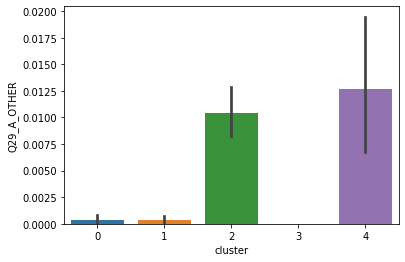

<Figure size 432x288 with 0 Axes>

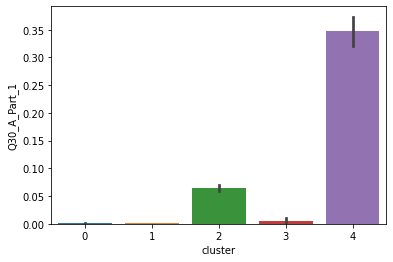

<Figure size 432x288 with 0 Axes>

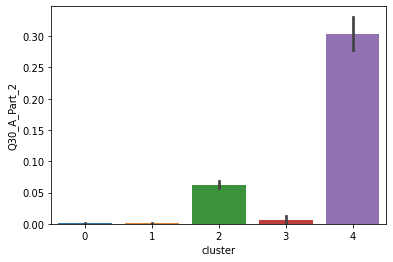

<Figure size 432x288 with 0 Axes>

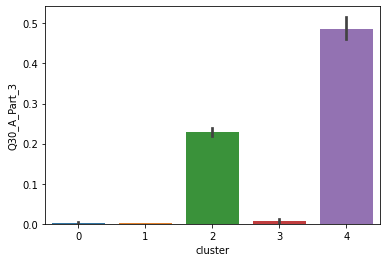

<Figure size 432x288 with 0 Axes>

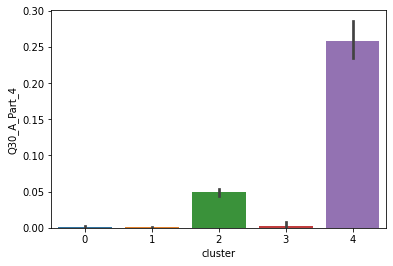

<Figure size 432x288 with 0 Axes>

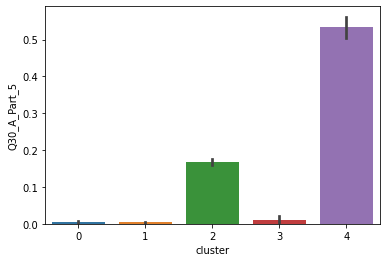

<Figure size 432x288 with 0 Axes>

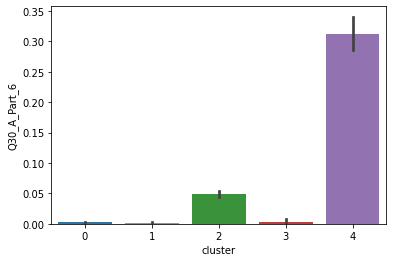

<Figure size 432x288 with 0 Axes>

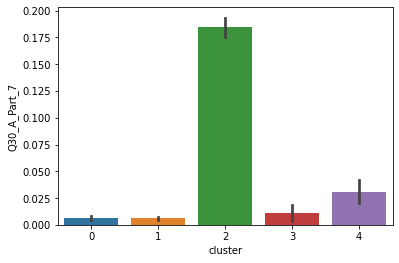

<Figure size 432x288 with 0 Axes>

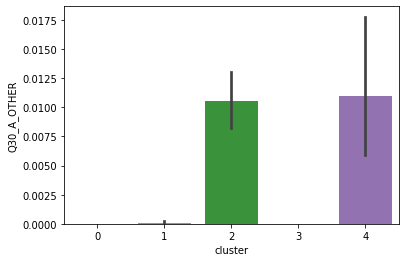

<Figure size 432x288 with 0 Axes>

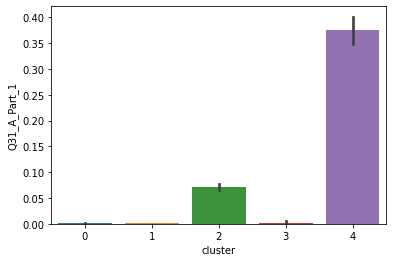

<Figure size 432x288 with 0 Axes>

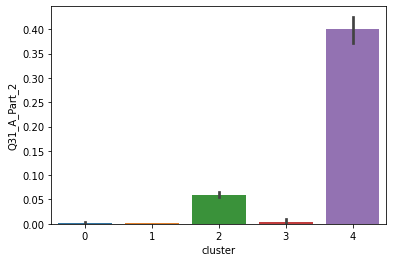

<Figure size 432x288 with 0 Axes>

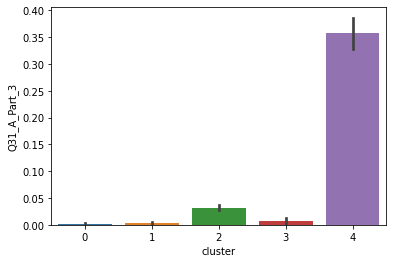

<Figure size 432x288 with 0 Axes>

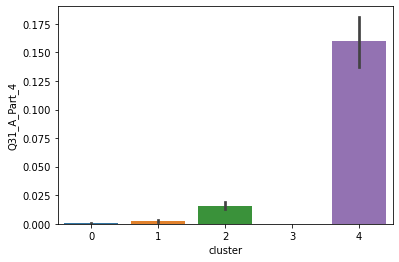

<Figure size 432x288 with 0 Axes>

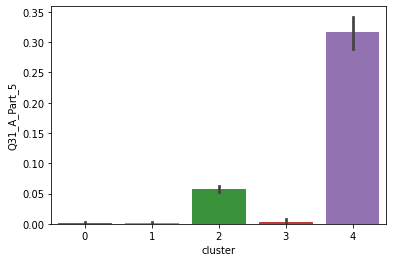

<Figure size 432x288 with 0 Axes>

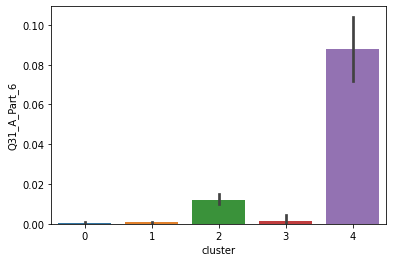

<Figure size 432x288 with 0 Axes>

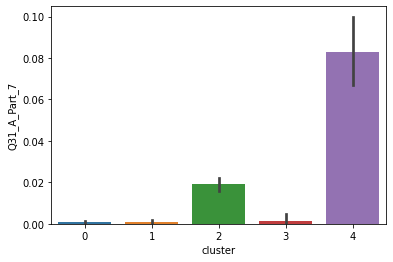

<Figure size 432x288 with 0 Axes>

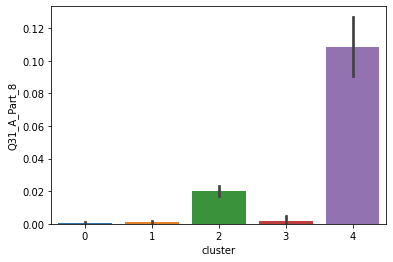

<Figure size 432x288 with 0 Axes>

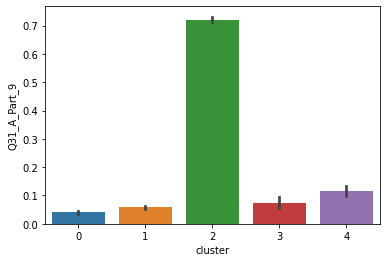

<Figure size 432x288 with 0 Axes>

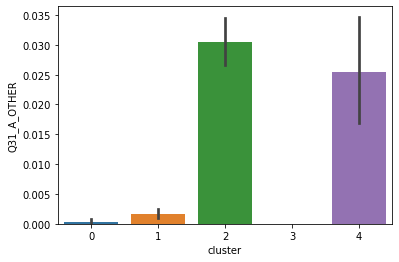

<Figure size 432x288 with 0 Axes>

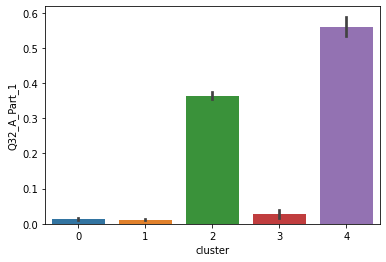

<Figure size 432x288 with 0 Axes>

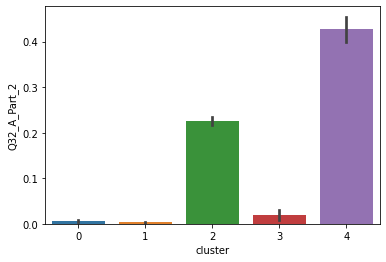

<Figure size 432x288 with 0 Axes>

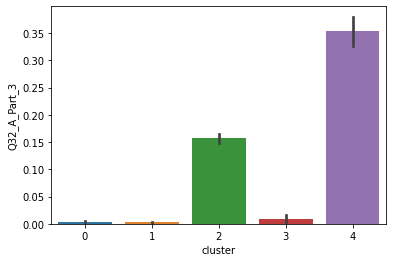

<Figure size 432x288 with 0 Axes>

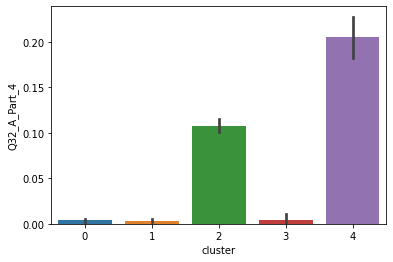

<Figure size 432x288 with 0 Axes>

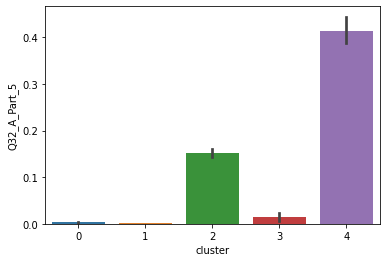

<Figure size 432x288 with 0 Axes>

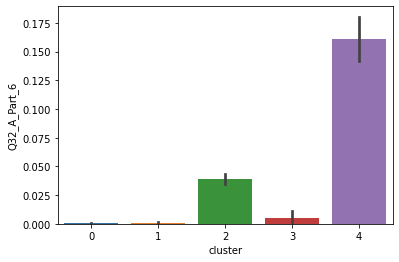

<Figure size 432x288 with 0 Axes>

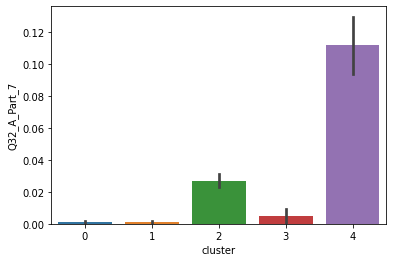

<Figure size 432x288 with 0 Axes>

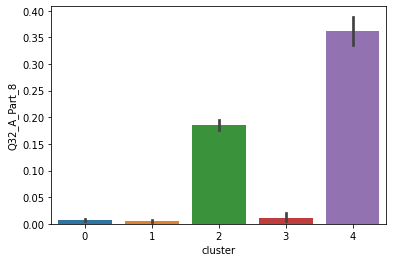

<Figure size 432x288 with 0 Axes>

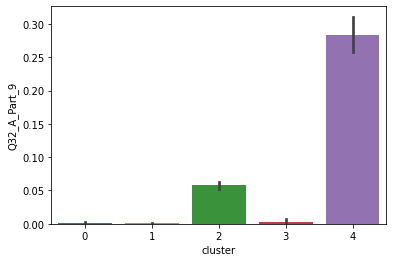

<Figure size 432x288 with 0 Axes>

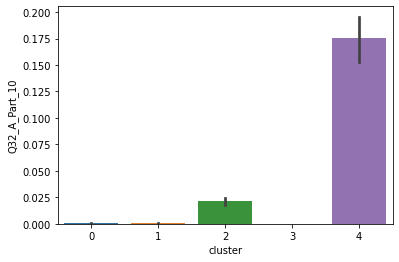

<Figure size 432x288 with 0 Axes>

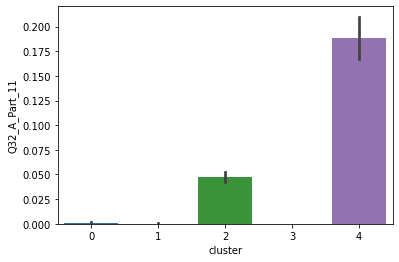

<Figure size 432x288 with 0 Axes>

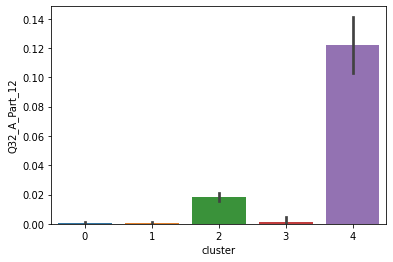

<Figure size 432x288 with 0 Axes>

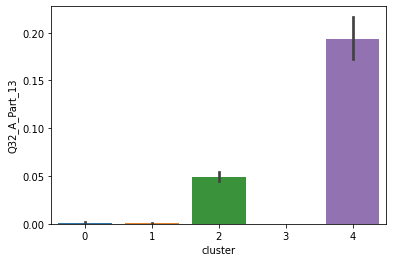

<Figure size 432x288 with 0 Axes>

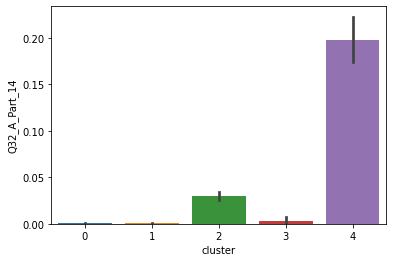

<Figure size 432x288 with 0 Axes>

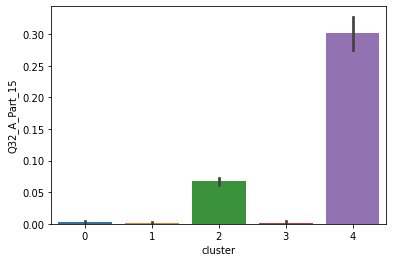

<Figure size 432x288 with 0 Axes>

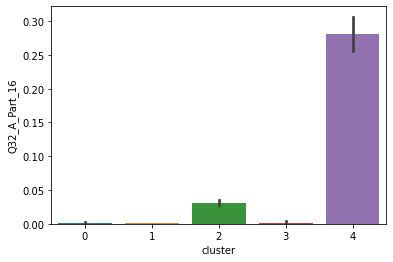

<Figure size 432x288 with 0 Axes>

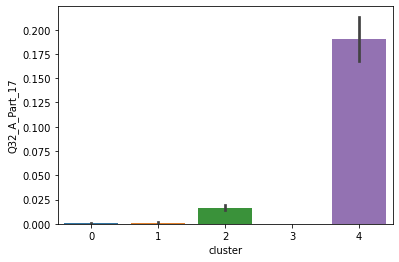

<Figure size 432x288 with 0 Axes>

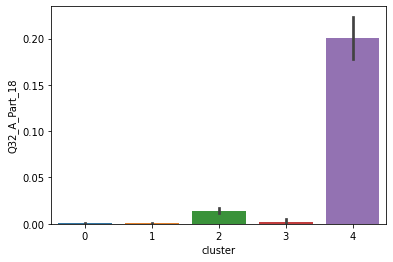

<Figure size 432x288 with 0 Axes>

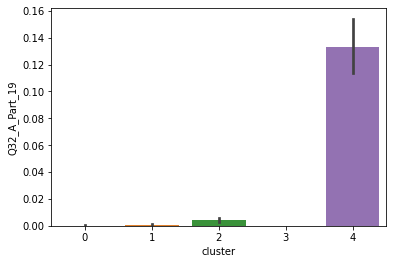

<Figure size 432x288 with 0 Axes>

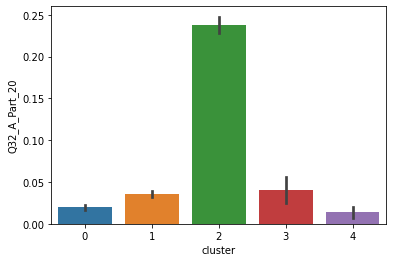

<Figure size 432x288 with 0 Axes>

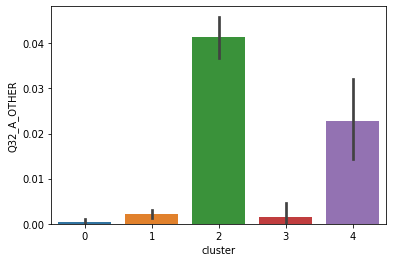

<Figure size 432x288 with 0 Axes>

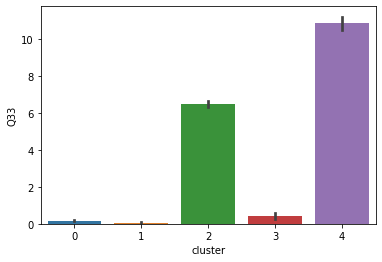

<Figure size 432x288 with 0 Axes>

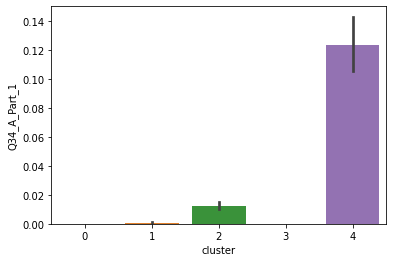

<Figure size 432x288 with 0 Axes>

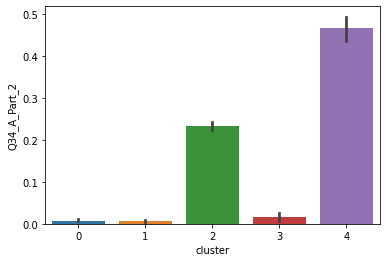

<Figure size 432x288 with 0 Axes>

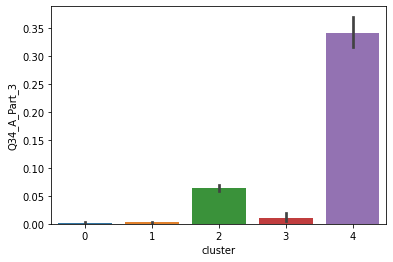

<Figure size 432x288 with 0 Axes>

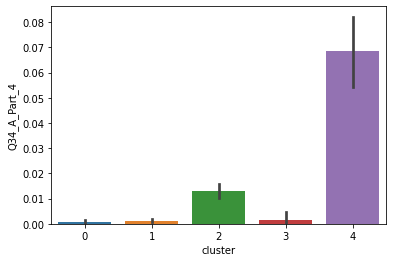

<Figure size 432x288 with 0 Axes>

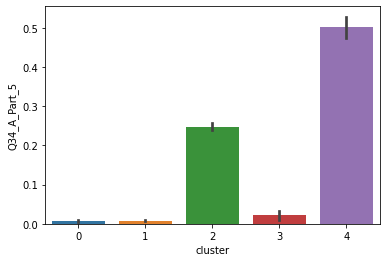

<Figure size 432x288 with 0 Axes>

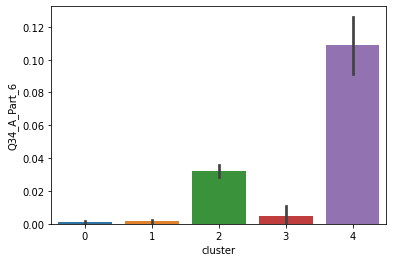

<Figure size 432x288 with 0 Axes>

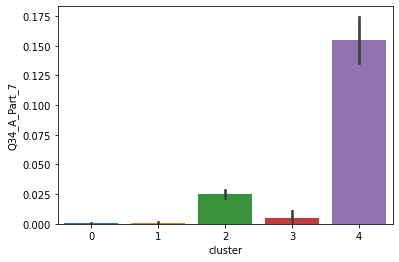

<Figure size 432x288 with 0 Axes>

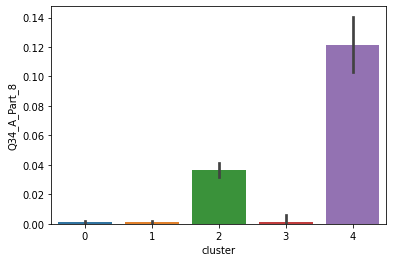

<Figure size 432x288 with 0 Axes>

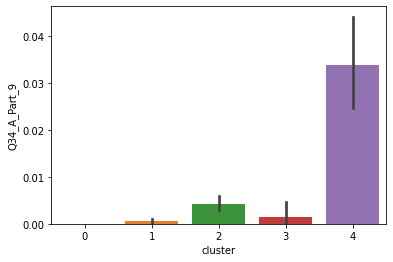

<Figure size 432x288 with 0 Axes>

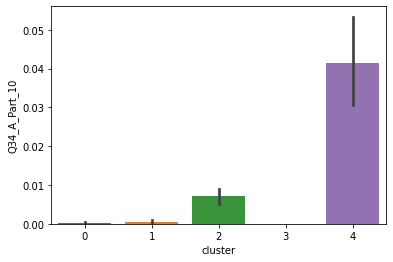

<Figure size 432x288 with 0 Axes>

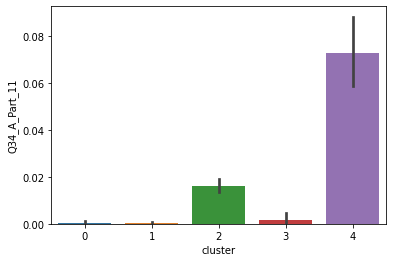

<Figure size 432x288 with 0 Axes>

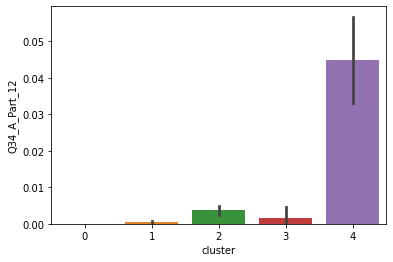

<Figure size 432x288 with 0 Axes>

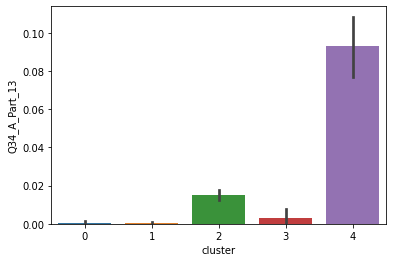

<Figure size 432x288 with 0 Axes>

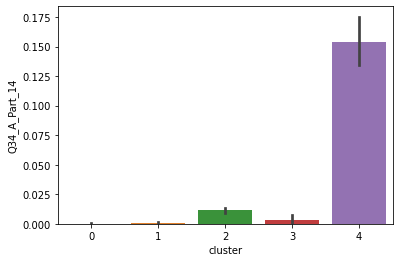

<Figure size 432x288 with 0 Axes>

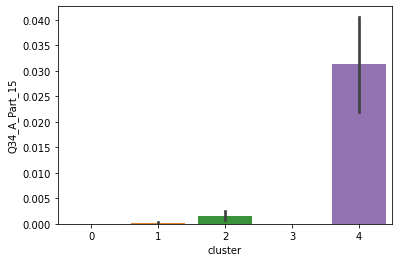

<Figure size 432x288 with 0 Axes>

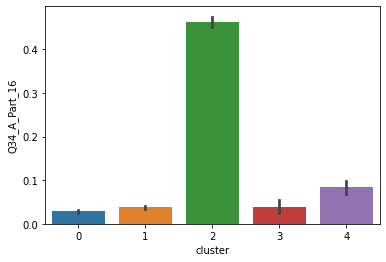

<Figure size 432x288 with 0 Axes>

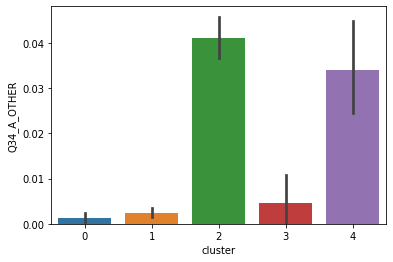

<Figure size 432x288 with 0 Axes>

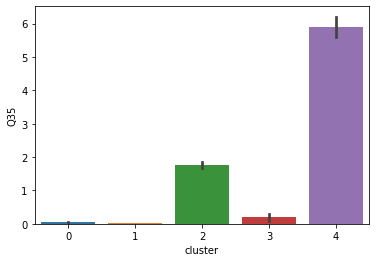

<Figure size 432x288 with 0 Axes>

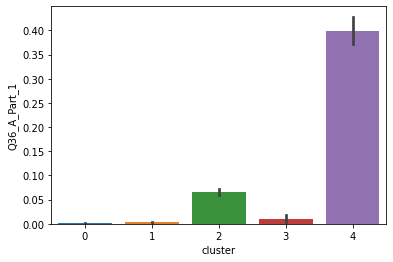

<Figure size 432x288 with 0 Axes>

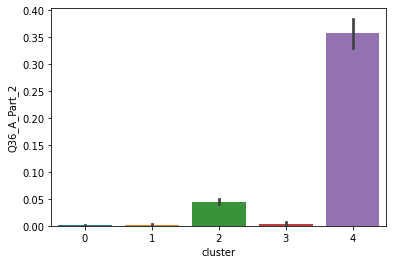

<Figure size 432x288 with 0 Axes>

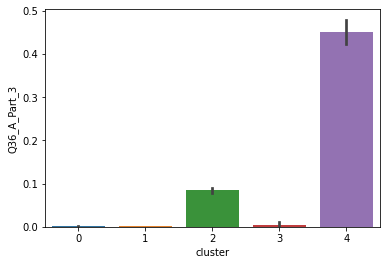

<Figure size 432x288 with 0 Axes>

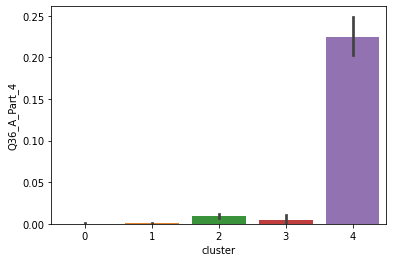

<Figure size 432x288 with 0 Axes>

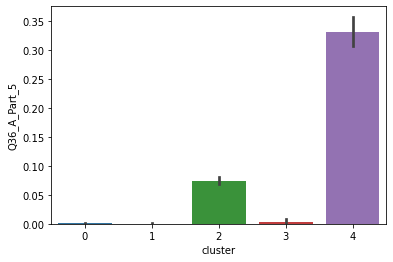

<Figure size 432x288 with 0 Axes>

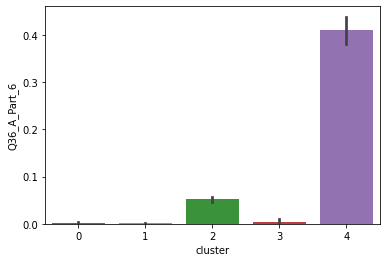

<Figure size 432x288 with 0 Axes>

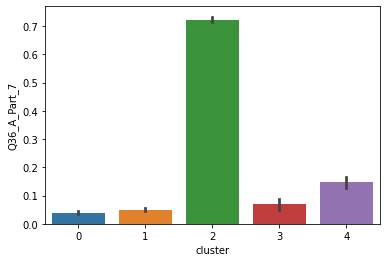

<Figure size 432x288 with 0 Axes>

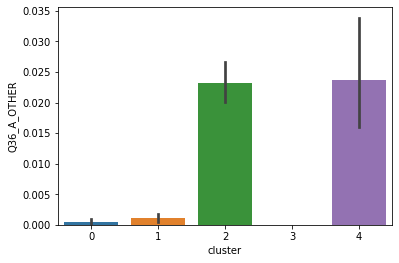

<Figure size 432x288 with 0 Axes>

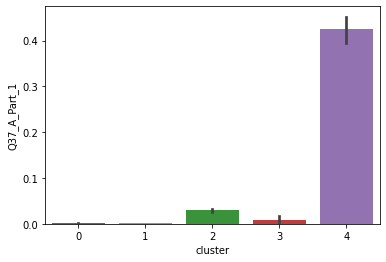

<Figure size 432x288 with 0 Axes>

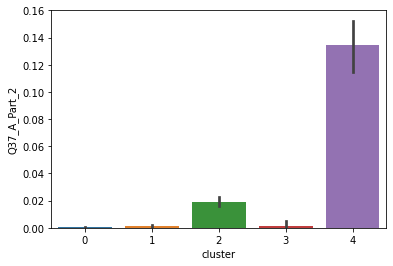

<Figure size 432x288 with 0 Axes>

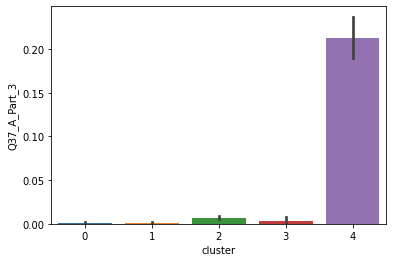

<Figure size 432x288 with 0 Axes>

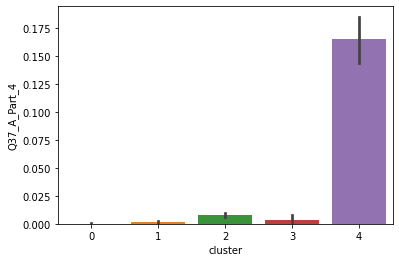

<Figure size 432x288 with 0 Axes>

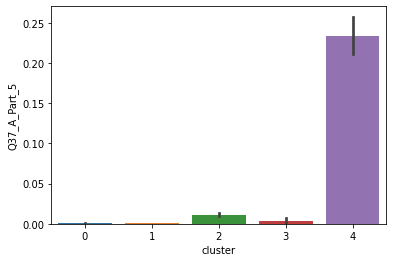

<Figure size 432x288 with 0 Axes>

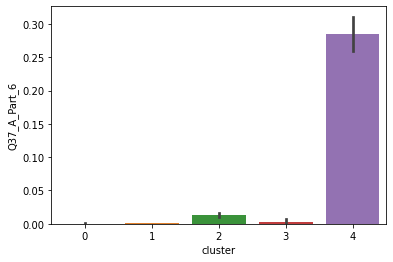

<Figure size 432x288 with 0 Axes>

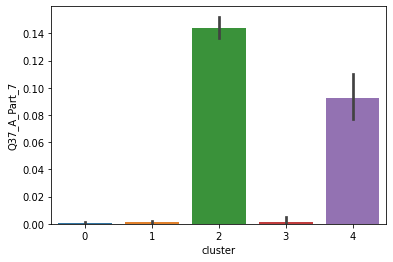

<Figure size 432x288 with 0 Axes>

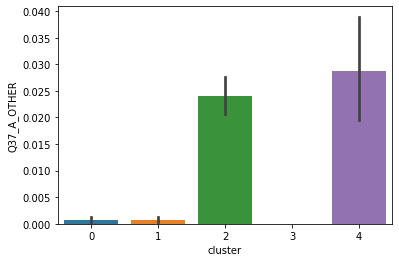

<Figure size 432x288 with 0 Axes>

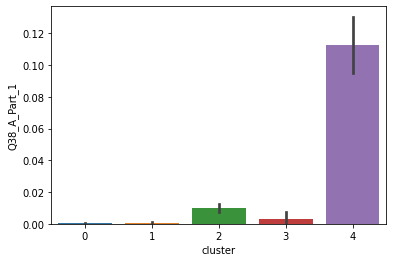

<Figure size 432x288 with 0 Axes>

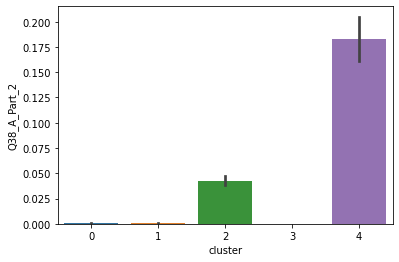

<Figure size 432x288 with 0 Axes>

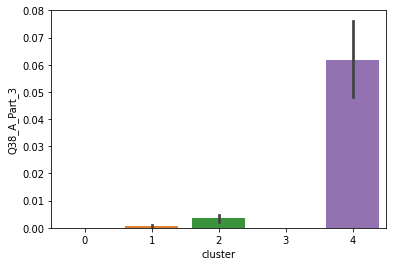

<Figure size 432x288 with 0 Axes>

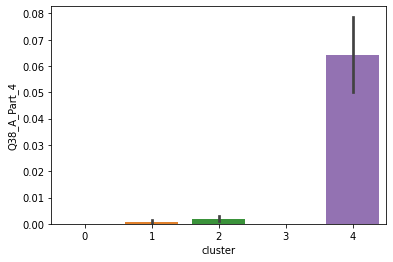

<Figure size 432x288 with 0 Axes>

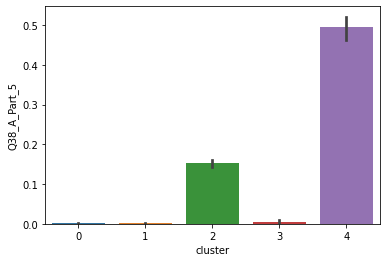

<Figure size 432x288 with 0 Axes>

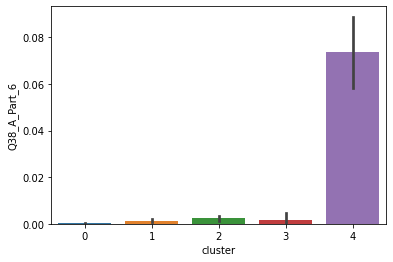

<Figure size 432x288 with 0 Axes>

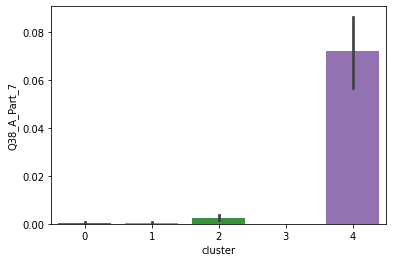

<Figure size 432x288 with 0 Axes>

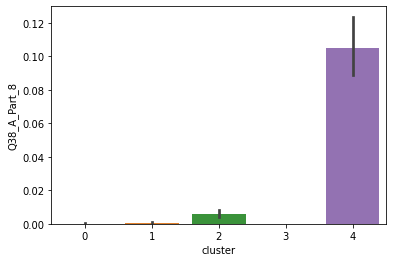

<Figure size 432x288 with 0 Axes>

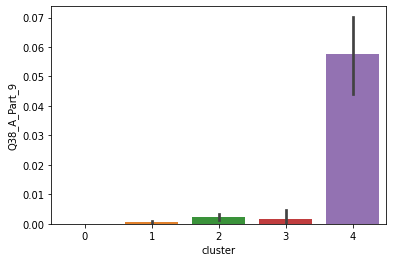

<Figure size 432x288 with 0 Axes>

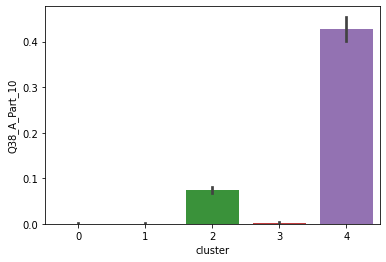

<Figure size 432x288 with 0 Axes>

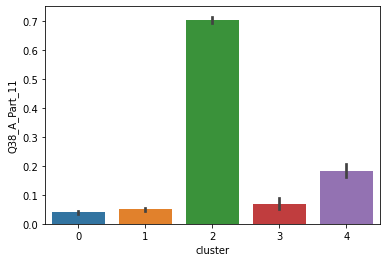

<Figure size 432x288 with 0 Axes>

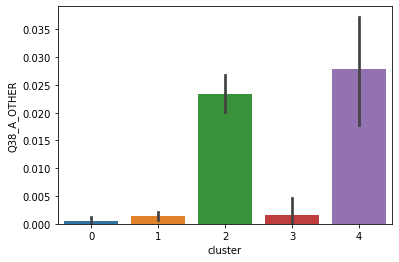

<Figure size 432x288 with 0 Axes>

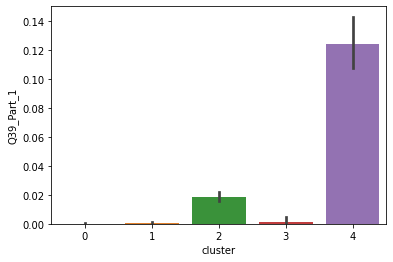

<Figure size 432x288 with 0 Axes>

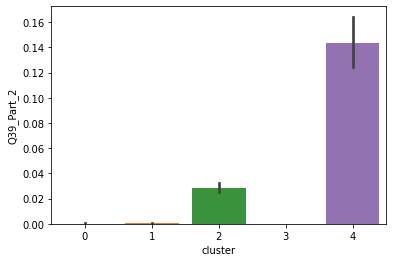

<Figure size 432x288 with 0 Axes>

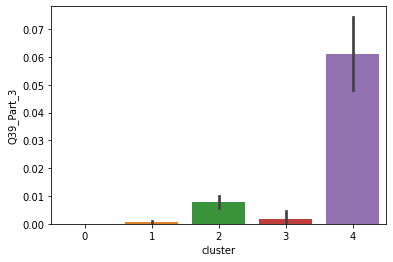

<Figure size 432x288 with 0 Axes>

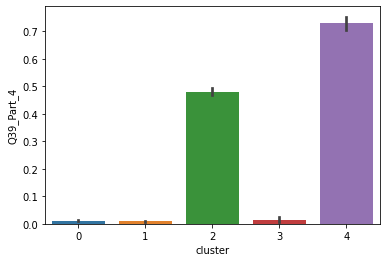

<Figure size 432x288 with 0 Axes>

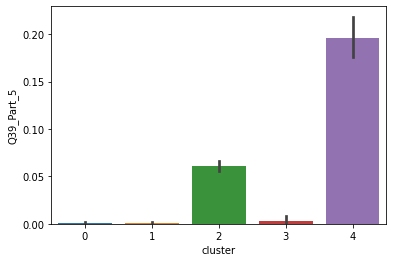

<Figure size 432x288 with 0 Axes>

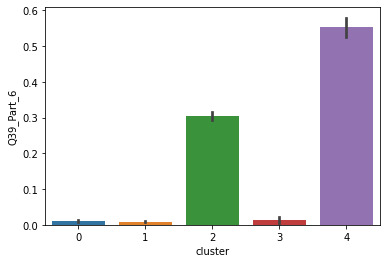

<Figure size 432x288 with 0 Axes>

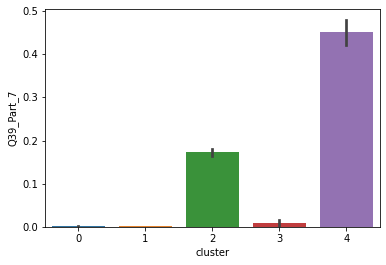

<Figure size 432x288 with 0 Axes>

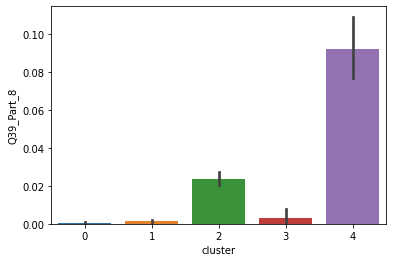

<Figure size 432x288 with 0 Axes>

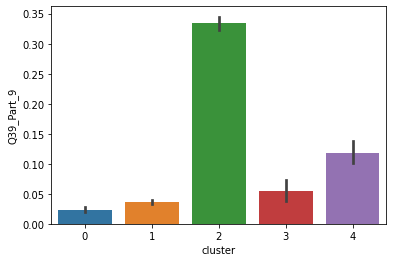

<Figure size 432x288 with 0 Axes>

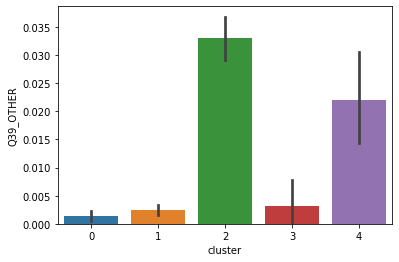

<Figure size 432x288 with 0 Axes>

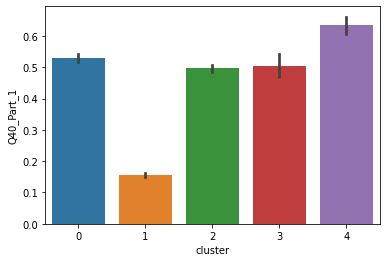

<Figure size 432x288 with 0 Axes>

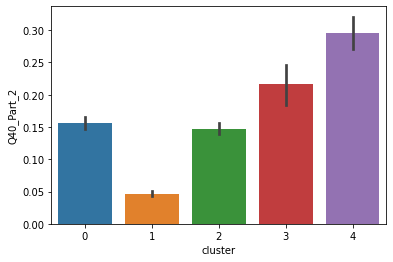

<Figure size 432x288 with 0 Axes>

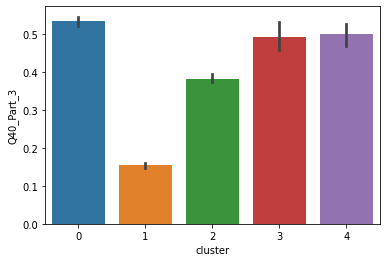

<Figure size 432x288 with 0 Axes>

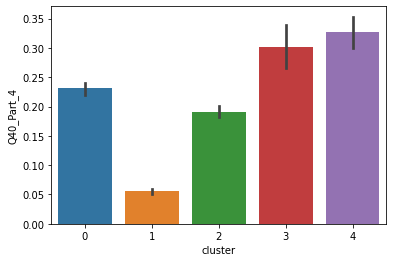

<Figure size 432x288 with 0 Axes>

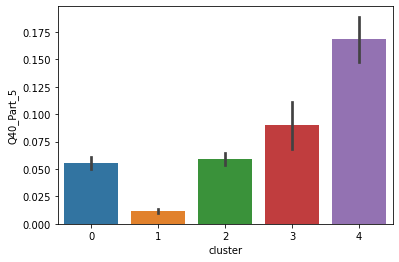

<Figure size 432x288 with 0 Axes>

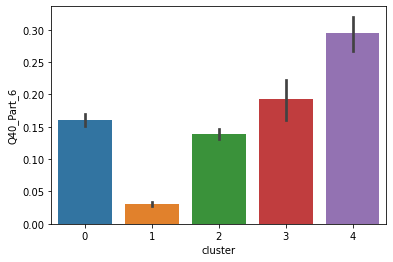

<Figure size 432x288 with 0 Axes>

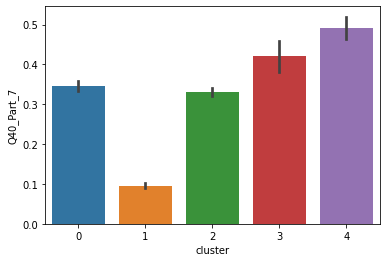

<Figure size 432x288 with 0 Axes>

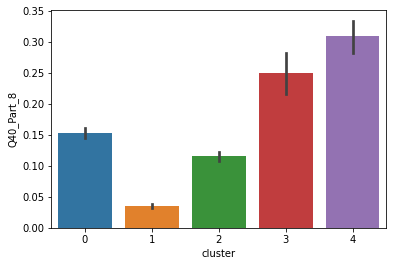

<Figure size 432x288 with 0 Axes>

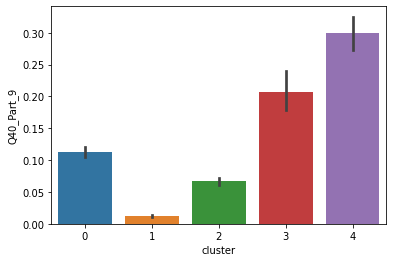

<Figure size 432x288 with 0 Axes>

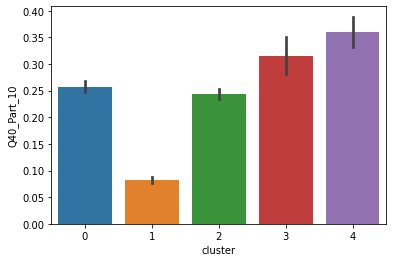

<Figure size 432x288 with 0 Axes>

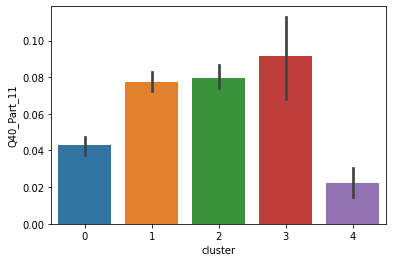

<Figure size 432x288 with 0 Axes>

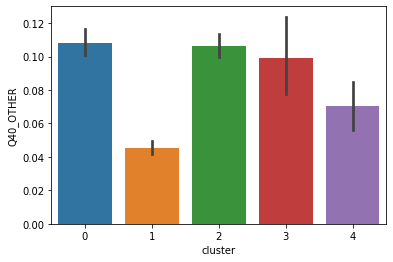

<Figure size 432x288 with 0 Axes>

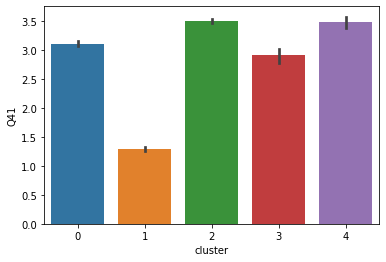

<Figure size 432x288 with 0 Axes>

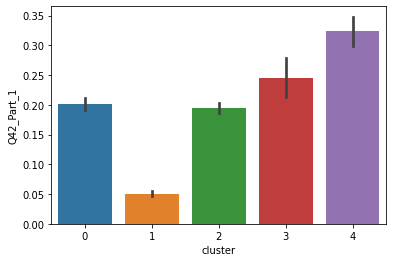

<Figure size 432x288 with 0 Axes>

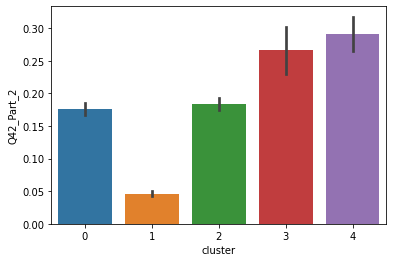

<Figure size 432x288 with 0 Axes>

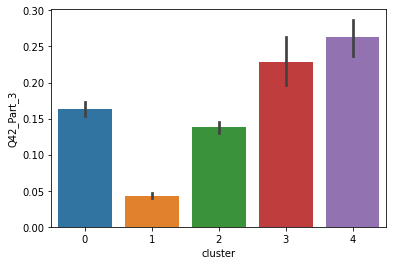

<Figure size 432x288 with 0 Axes>

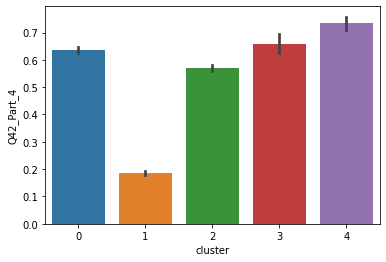

<Figure size 432x288 with 0 Axes>

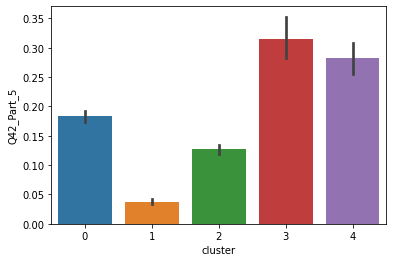

<Figure size 432x288 with 0 Axes>

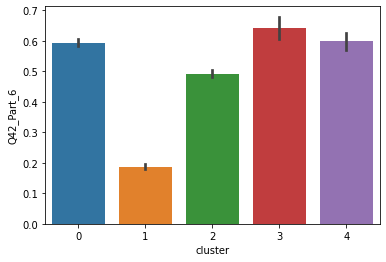

<Figure size 432x288 with 0 Axes>

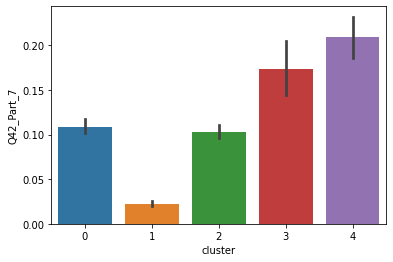

<Figure size 432x288 with 0 Axes>

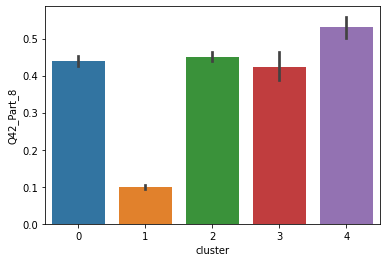

<Figure size 432x288 with 0 Axes>

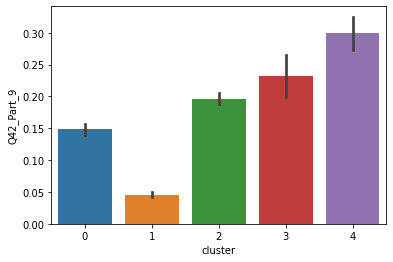

<Figure size 432x288 with 0 Axes>

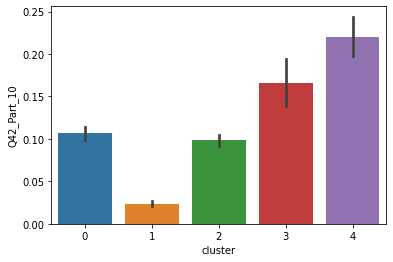

<Figure size 432x288 with 0 Axes>

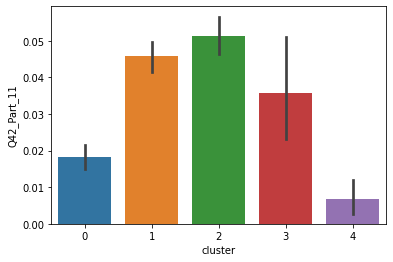

<Figure size 432x288 with 0 Axes>

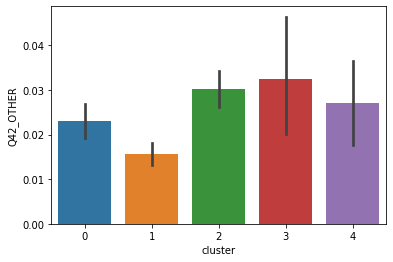

<Figure size 432x288 with 0 Axes>

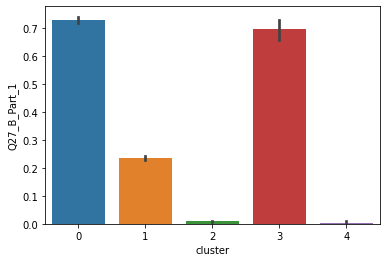

<Figure size 432x288 with 0 Axes>

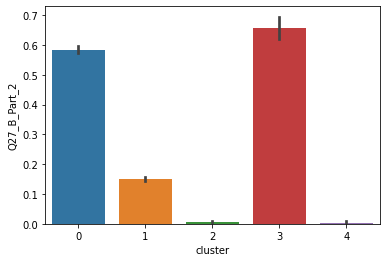

<Figure size 432x288 with 0 Axes>

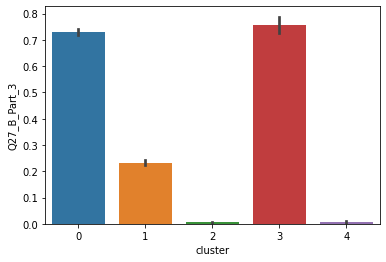

<Figure size 432x288 with 0 Axes>

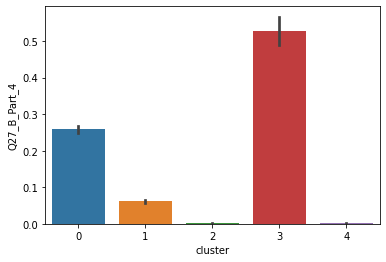

<Figure size 432x288 with 0 Axes>

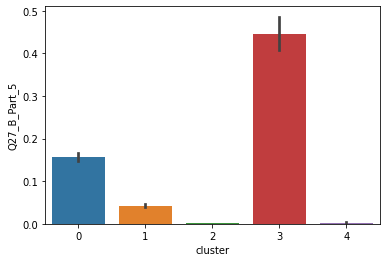

<Figure size 432x288 with 0 Axes>

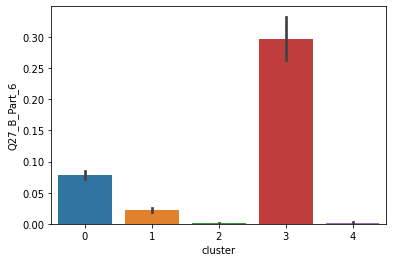

<Figure size 432x288 with 0 Axes>

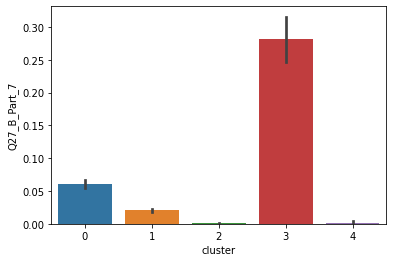

<Figure size 432x288 with 0 Axes>

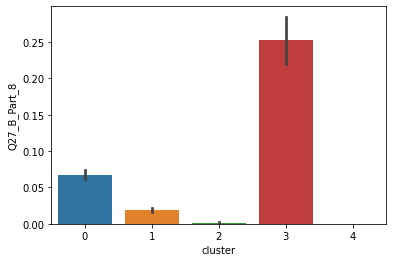

<Figure size 432x288 with 0 Axes>

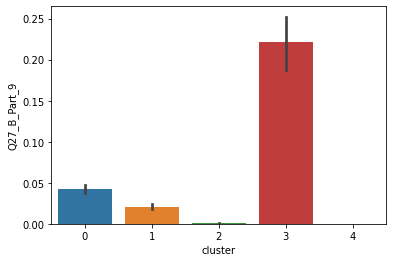

<Figure size 432x288 with 0 Axes>

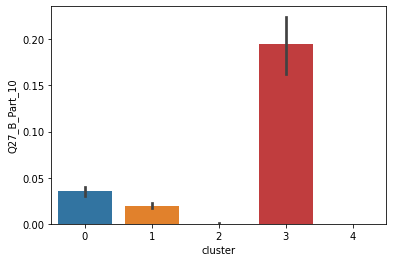

<Figure size 432x288 with 0 Axes>

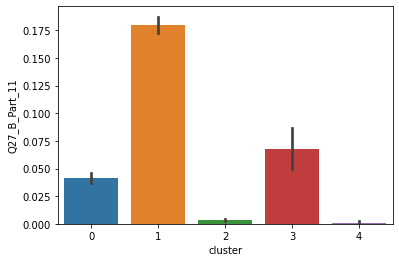

<Figure size 432x288 with 0 Axes>

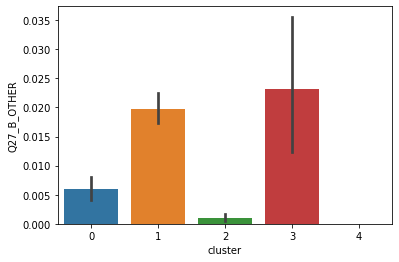

<Figure size 432x288 with 0 Axes>

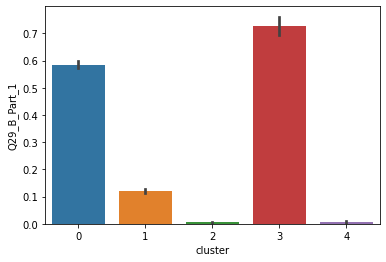

<Figure size 432x288 with 0 Axes>

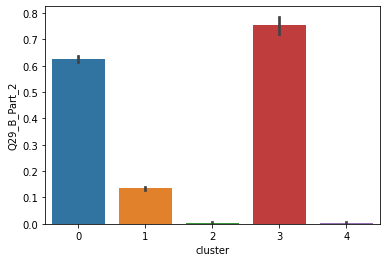

<Figure size 432x288 with 0 Axes>

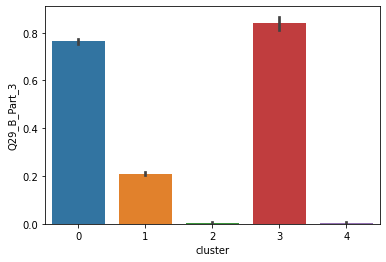

<Figure size 432x288 with 0 Axes>

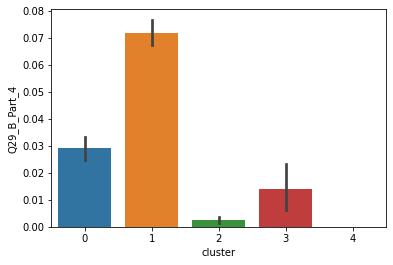

<Figure size 432x288 with 0 Axes>

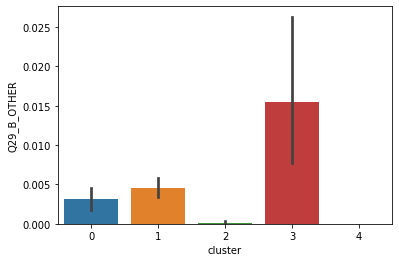

<Figure size 432x288 with 0 Axes>

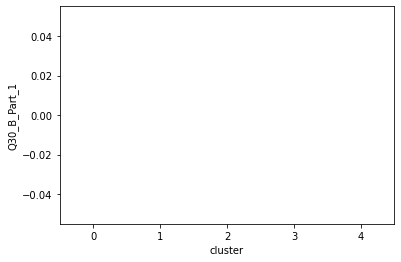

<Figure size 432x288 with 0 Axes>

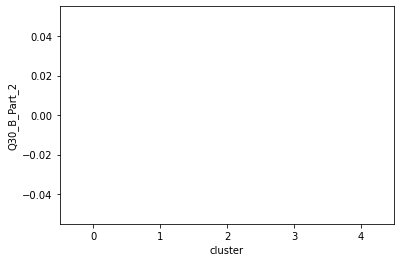

<Figure size 432x288 with 0 Axes>

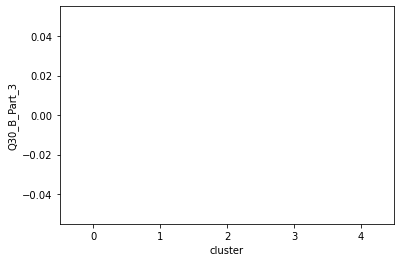

<Figure size 432x288 with 0 Axes>

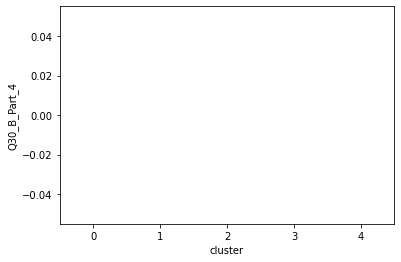

<Figure size 432x288 with 0 Axes>

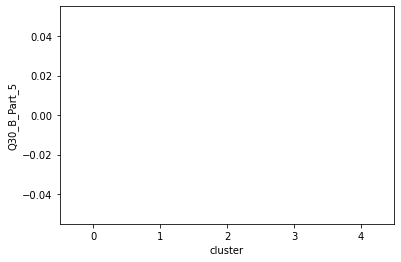

<Figure size 432x288 with 0 Axes>

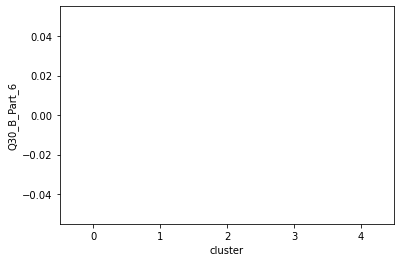

<Figure size 432x288 with 0 Axes>

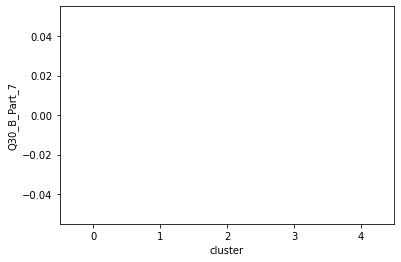

<Figure size 432x288 with 0 Axes>

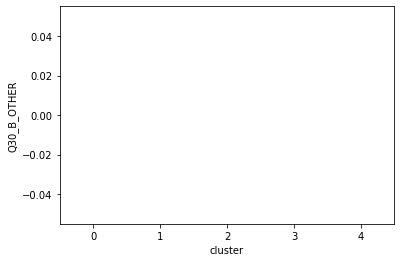

<Figure size 432x288 with 0 Axes>

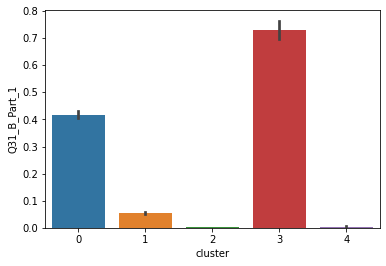

<Figure size 432x288 with 0 Axes>

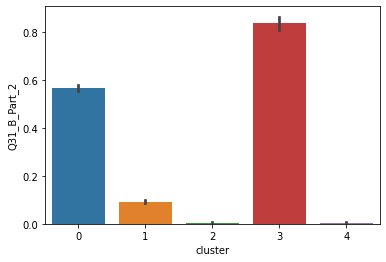

<Figure size 432x288 with 0 Axes>

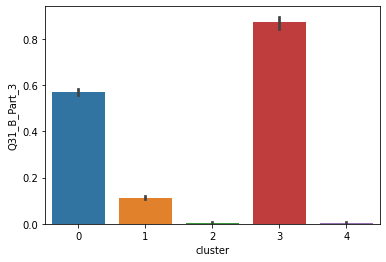

<Figure size 432x288 with 0 Axes>

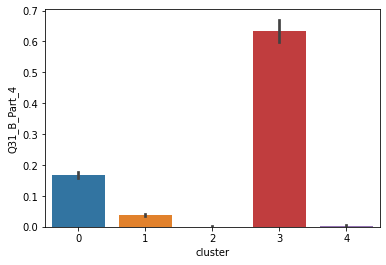

<Figure size 432x288 with 0 Axes>

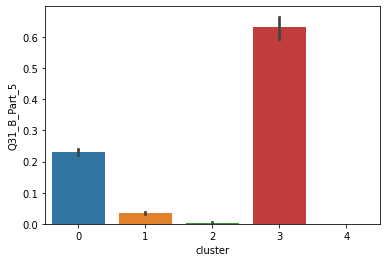

<Figure size 432x288 with 0 Axes>

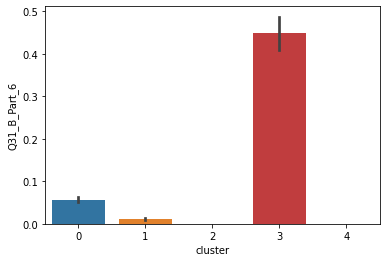

<Figure size 432x288 with 0 Axes>

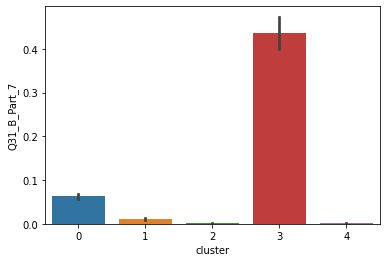

<Figure size 432x288 with 0 Axes>

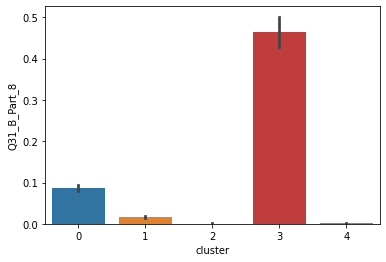

<Figure size 432x288 with 0 Axes>

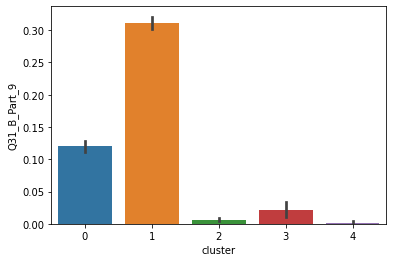

<Figure size 432x288 with 0 Axes>

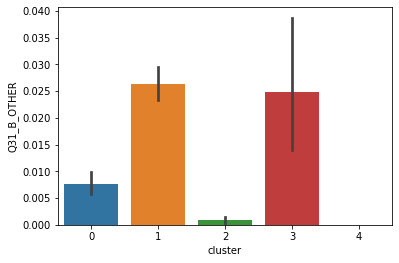

<Figure size 432x288 with 0 Axes>

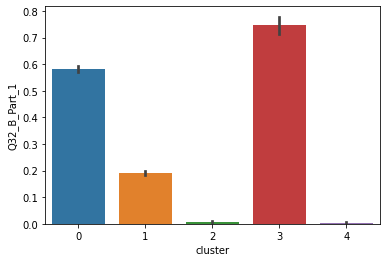

<Figure size 432x288 with 0 Axes>

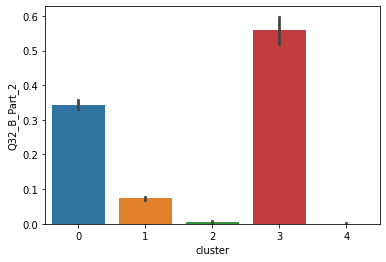

<Figure size 432x288 with 0 Axes>

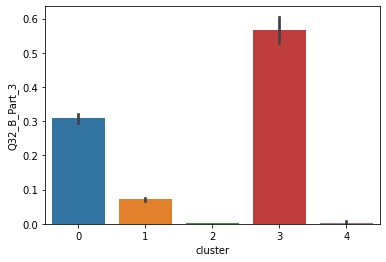

<Figure size 432x288 with 0 Axes>

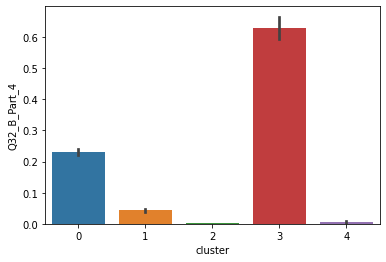

<Figure size 432x288 with 0 Axes>

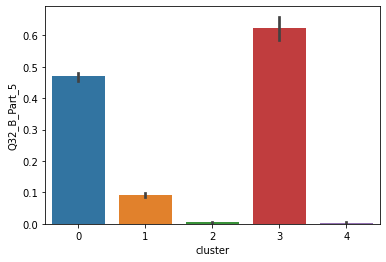

<Figure size 432x288 with 0 Axes>

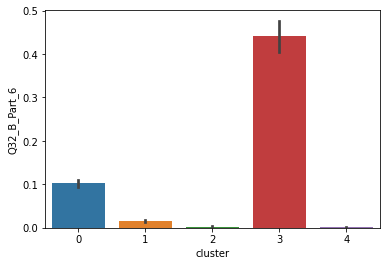

<Figure size 432x288 with 0 Axes>

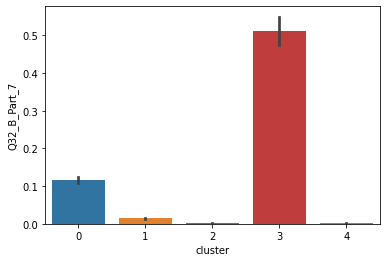

<Figure size 432x288 with 0 Axes>

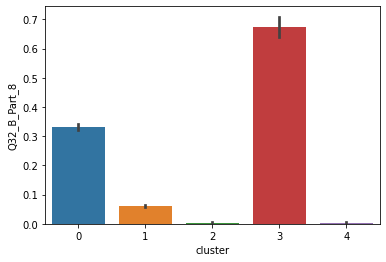

<Figure size 432x288 with 0 Axes>

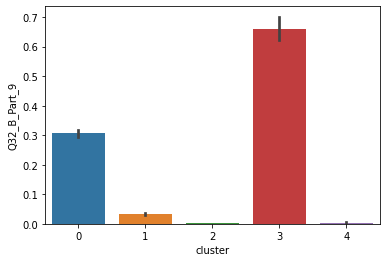

<Figure size 432x288 with 0 Axes>

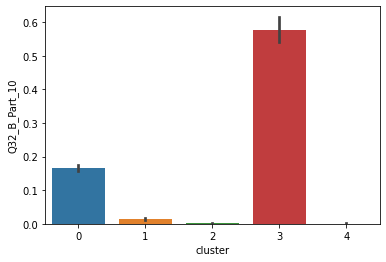

<Figure size 432x288 with 0 Axes>

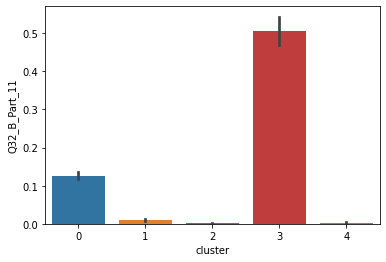

<Figure size 432x288 with 0 Axes>

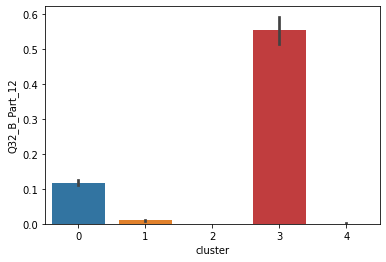

<Figure size 432x288 with 0 Axes>

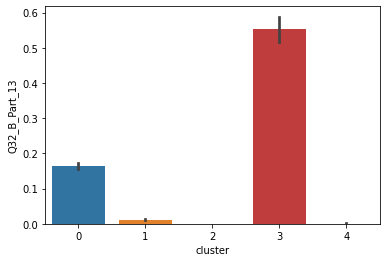

<Figure size 432x288 with 0 Axes>

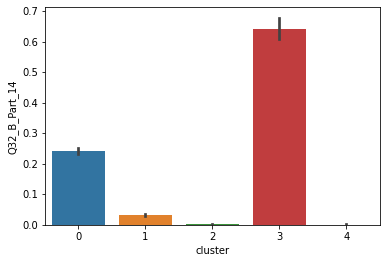

<Figure size 432x288 with 0 Axes>

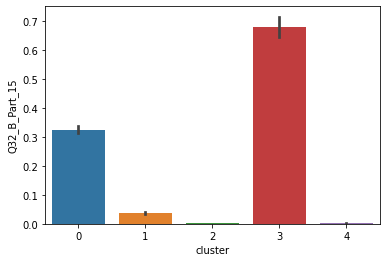

<Figure size 432x288 with 0 Axes>

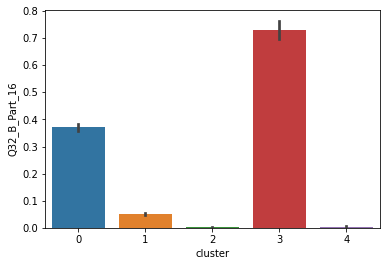

<Figure size 432x288 with 0 Axes>

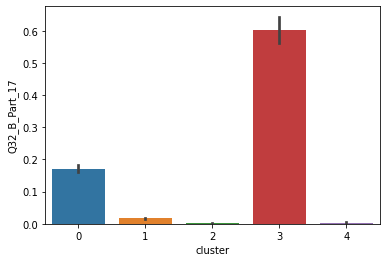

<Figure size 432x288 with 0 Axes>

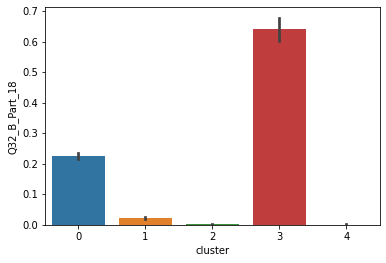

<Figure size 432x288 with 0 Axes>

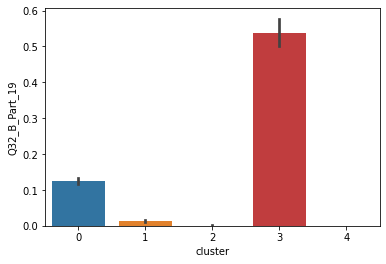

<Figure size 432x288 with 0 Axes>

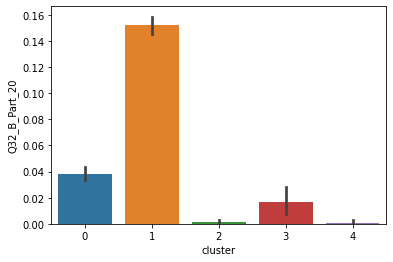

<Figure size 432x288 with 0 Axes>

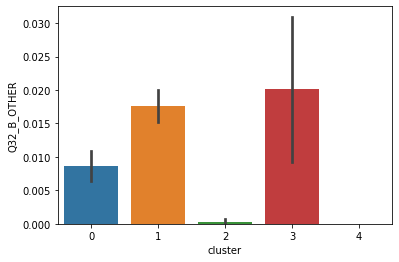

<Figure size 432x288 with 0 Axes>

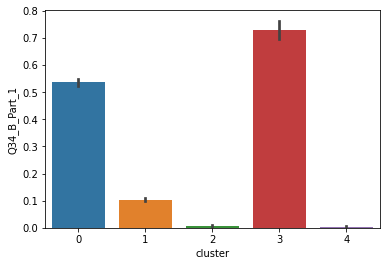

<Figure size 432x288 with 0 Axes>

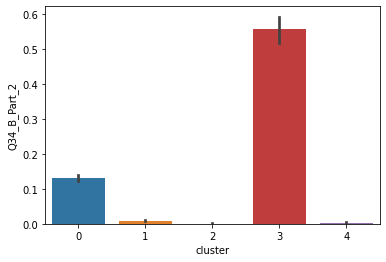

<Figure size 432x288 with 0 Axes>

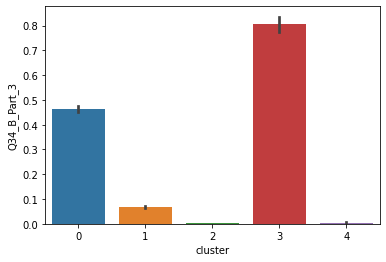

<Figure size 432x288 with 0 Axes>

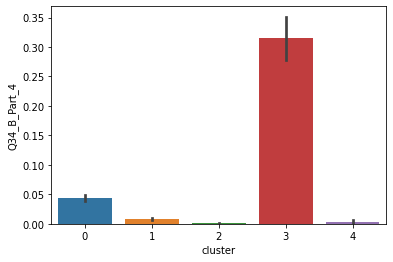

<Figure size 432x288 with 0 Axes>

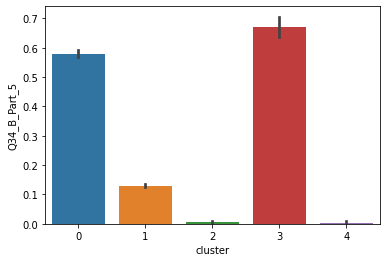

<Figure size 432x288 with 0 Axes>

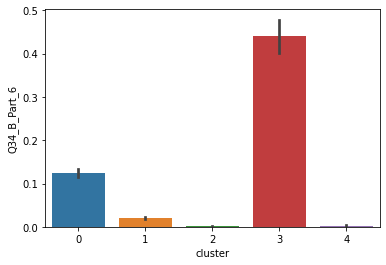

<Figure size 432x288 with 0 Axes>

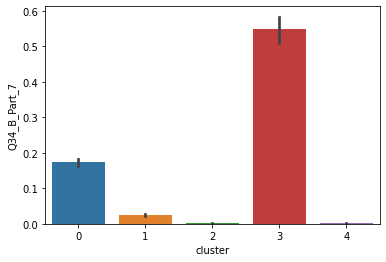

<Figure size 432x288 with 0 Axes>

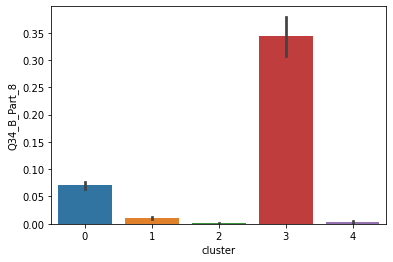

<Figure size 432x288 with 0 Axes>

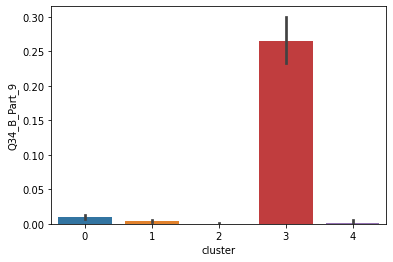

<Figure size 432x288 with 0 Axes>

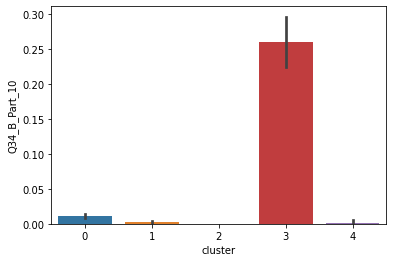

<Figure size 432x288 with 0 Axes>

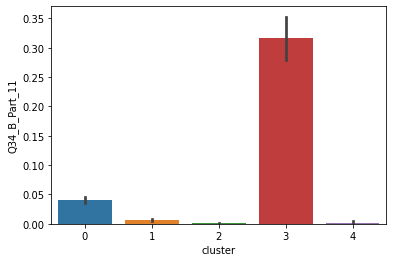

<Figure size 432x288 with 0 Axes>

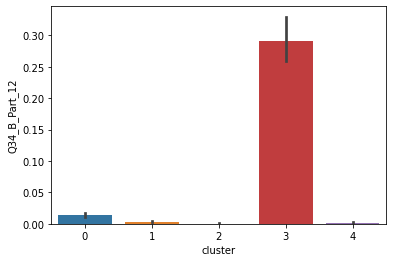

<Figure size 432x288 with 0 Axes>

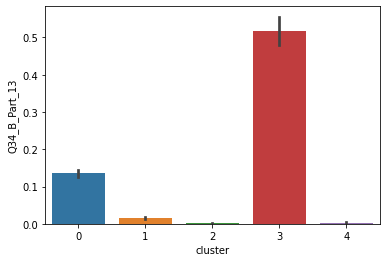

<Figure size 432x288 with 0 Axes>

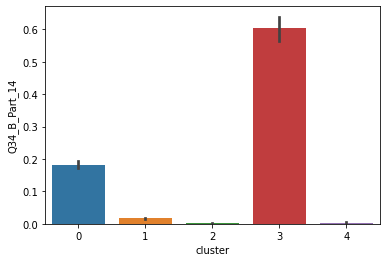

<Figure size 432x288 with 0 Axes>

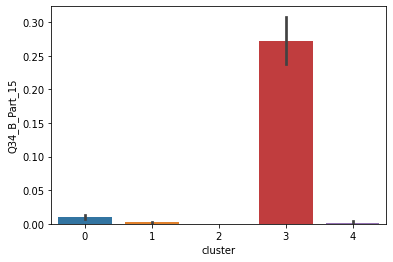

<Figure size 432x288 with 0 Axes>

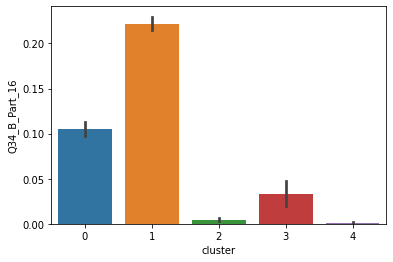

<Figure size 432x288 with 0 Axes>

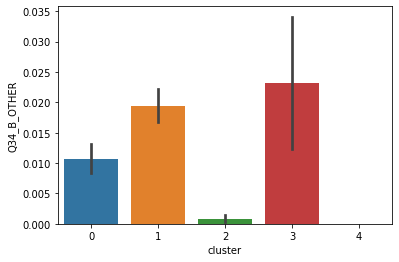

<Figure size 432x288 with 0 Axes>

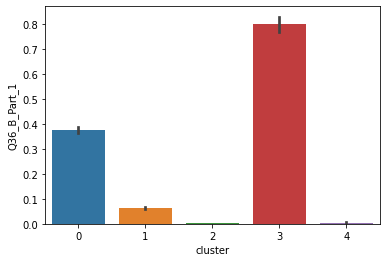

<Figure size 432x288 with 0 Axes>

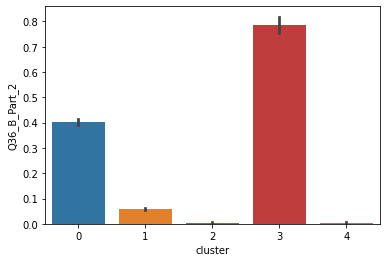

<Figure size 432x288 with 0 Axes>

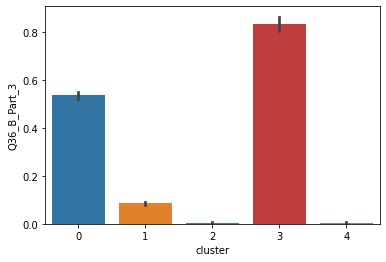

<Figure size 432x288 with 0 Axes>

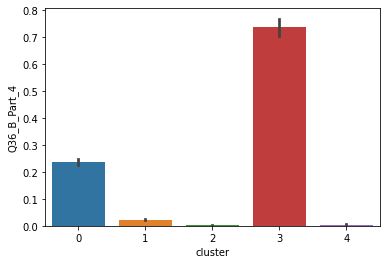

<Figure size 432x288 with 0 Axes>

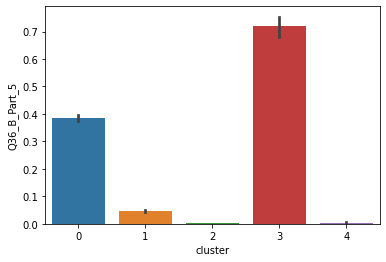

<Figure size 432x288 with 0 Axes>

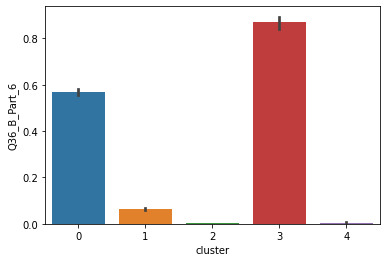

<Figure size 432x288 with 0 Axes>

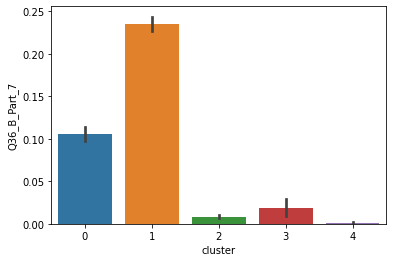

<Figure size 432x288 with 0 Axes>

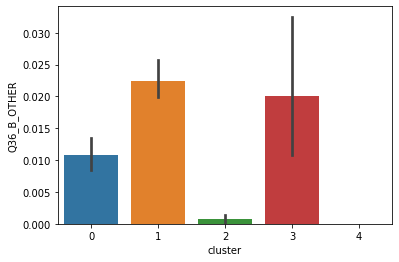

<Figure size 432x288 with 0 Axes>

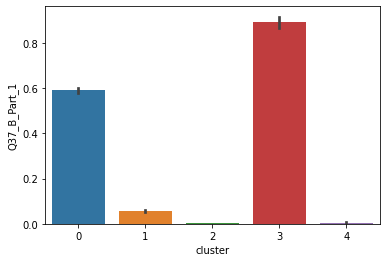

<Figure size 432x288 with 0 Axes>

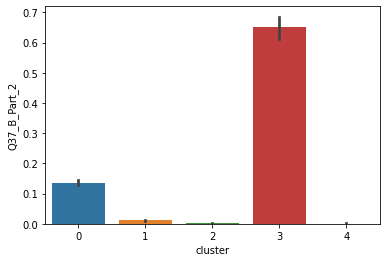

<Figure size 432x288 with 0 Axes>

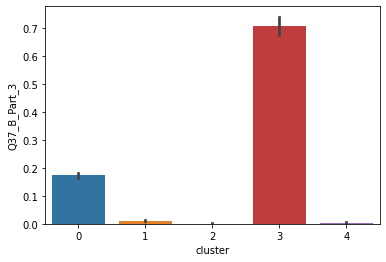

<Figure size 432x288 with 0 Axes>

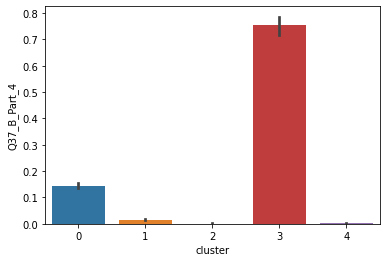

<Figure size 432x288 with 0 Axes>

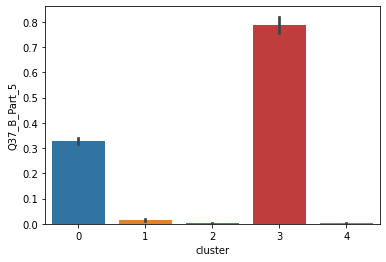

<Figure size 432x288 with 0 Axes>

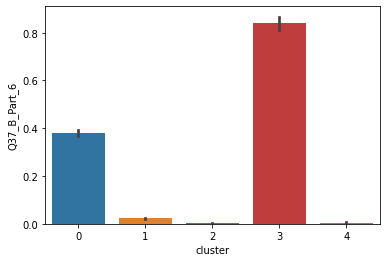

<Figure size 432x288 with 0 Axes>

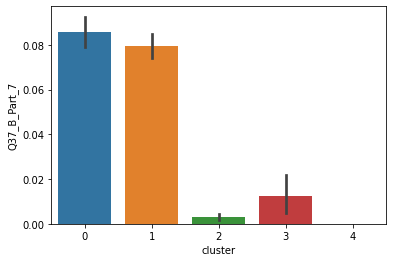

<Figure size 432x288 with 0 Axes>

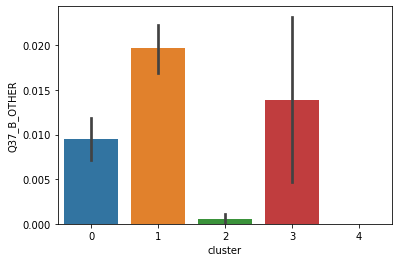

<Figure size 432x288 with 0 Axes>

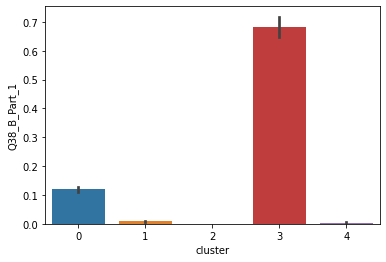

<Figure size 432x288 with 0 Axes>

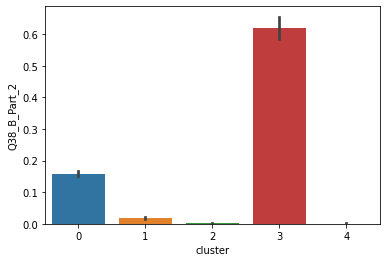

<Figure size 432x288 with 0 Axes>

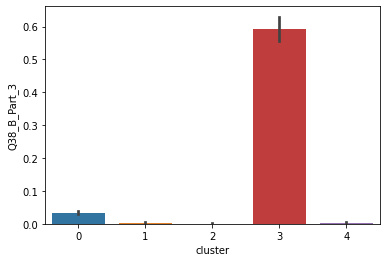

<Figure size 432x288 with 0 Axes>

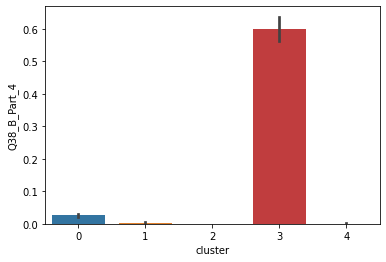

<Figure size 432x288 with 0 Axes>

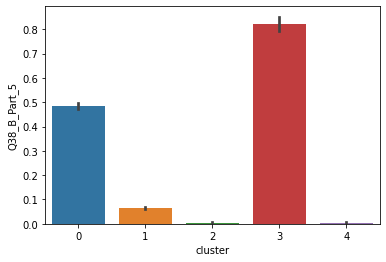

<Figure size 432x288 with 0 Axes>

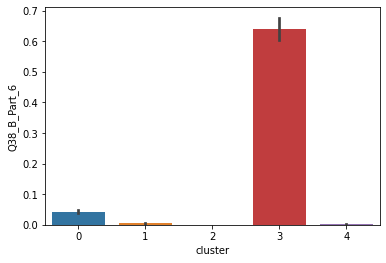

<Figure size 432x288 with 0 Axes>

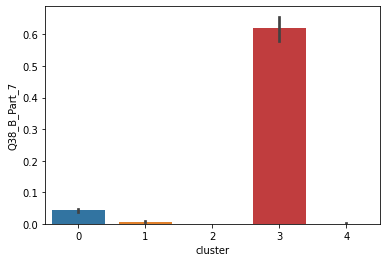

<Figure size 432x288 with 0 Axes>

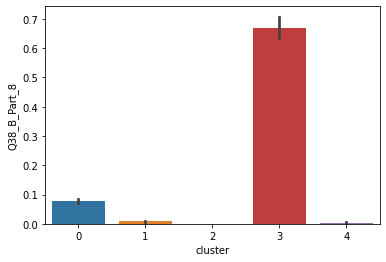

<Figure size 432x288 with 0 Axes>

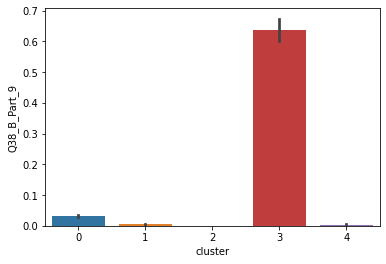

<Figure size 432x288 with 0 Axes>

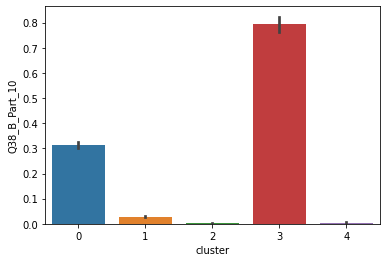

<Figure size 432x288 with 0 Axes>

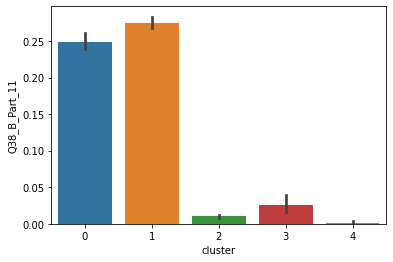

<Figure size 432x288 with 0 Axes>

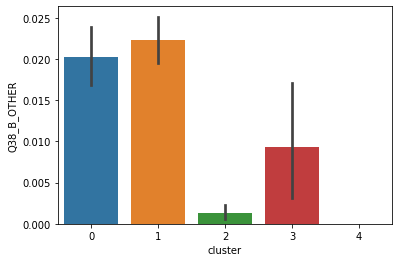

<Figure size 432x288 with 0 Axes>

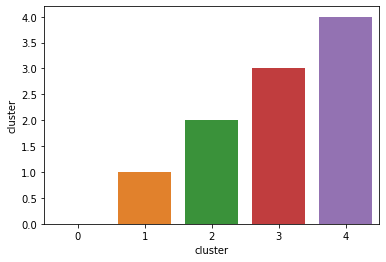

In [34]:
# 전체 컬럼에서 클러스터별 단순히 시각화로 확인해보기 --시간 많이 소요됩니다!!
for i in df.columns:
  plt.figure()
  fig, ax = plt.subplots()
  sns.barplot(ax=ax, x='cluster', y=i, data=df)
  plt.show()